In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("/data/tim/heronWorkspace/src")
sys.path.append("/data/tim/heronWorkspace/AE")
sys.path.append("/data/tim/heronWorkspace/classifier")
sys.path.append("/data/tim/heronWorkspace/")


from AEHeronModelV1 import AEHeronModel
from AEHeronModelV2 import CAEHeron
from lightning.pytorch.callbacks import ModelSummary
from torchsummary import summary
import HeronImageLoader
from torch.utils.data import DataLoader, BatchSampler
from matplotlib import pyplot as plt
import lightning.pytorch as pl
from lightning.pytorch.tuner import Tuner
import pandas as pd
from lightning.pytorch.loggers import CSVLogger
from MLPV1 import MLP, MLPMSEHeatMap
from models import MLPBasic, CAEBigBottleneck, CAESmallBottleneckWithLinear, MLPBasicHeatMap, CAEV1
import numpy as np
import torch.nn.functional as F
import torch
from torchvision.transforms import GaussianBlur
from PIL import Image, ImageFilter
import random
from scipy.stats import loguniform
from ClassifierDatasets import DatasetThreeConsecutive, UnNormalize
# from torchmetrics.image import StructuralSimilarityIndexMeasure
from skimage.metrics import structural_similarity as ssim
import seaborn as sns
from sklearn.model_selection import ParameterSampler
from scipy.stats import loguniform
import functorch
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
# from torchmetrics import ConfusionMatrix

sns.set_theme()




# Params:
- different CAE
- cameraProps - cutoff on the sides
- gaussian filter params / min-filter params
- zero thresholds
- sum threshold
- dataset props

In [46]:
loaderParams = dict(
    lblValidationMode = "Manual",
    balanced = True,
    anomalyObviousness = "obvious",
    distinctCAETraining = False,
    colorMode = "RGB",
    random_state = 1,
    set = "train"
)

distributions = dict(
    cameras = [["NEN1", "SBU3"]], #, ["SBU4"]
    balanced = [True, False],
    distinctCAETraining = [True, False],
    gaussianFilterSize = [3, 5],
    gaussianFilterSigma = [3, 5],
    filter = ["MinFilter"], #["MinFilter", "GaussianFilter"]
    zeroThreshold = np.random.uniform(low=0.15, high=0.4, size=30), # uniform dist on loc, loc+scale -> uniform(loc, scale) #threshold for zeroing out the image
    sumThreshold = np.random.uniform(low=20, high=70, size=30),
    lossFn = ["L1"]#["MSE", "L1"],
)

sampler = ParameterSampler(distributions, n_iter=30, random_state=loaderParams["random_state"])

includeCameraProps = False
model = CAEV1

checkPoint = '/data/tim/heronWorkspace/logs/CAEV1/version_3/checkpoints/epoch=49-step=19350.ckpt'
caeLoaded = CAEHeron.load_from_checkpoint(checkPoint, model = model)
caeLoaded.freeze()
print(caeLoaded.hparams)

fileName = "basicCAETest"
columns = ["trueLbl", "predictedLbl", "ImagePath", "includeCameraProps", "CAECheckPoint", "isCAETrainingCamera"] + list(loaderParams.keys()) + list(distributions.keys()) 
try:
    df = pd.read_csv(f"/data/tim/heronWorkspace/caeTestData/{fileName}.csv")
except:
    df = pd.DataFrame(columns=columns)


"batch_size":         16
"bottleneck":         128
"cameras":            ['NEN1', 'SBU3']
"gammaScheduler":     0.7879353477950641
"ldim":               16
"learning_rate":      0.003533238255084643
"num_workers_loader": 4
"transforms":         None
"weight_decay":       4.5387898639621974e-07


In [7]:
def min_filter(tensor : torch.Tensor, kernel_size=3):
    # Unfold the tensor into sliding local blocks
    unfolded = tensor.unfold(0, kernel_size, 1)
    unfolded = unfolded.unfold(1, kernel_size, 1)
    # Compute the minimum in each of these blocks
    return unfolded.min(dim=-1)[0].min(dim=-1)[0]

In [7]:
a = torch.tensor([[[0] * 5, [1] * 5, [2] * 5, [3] * 5, [4] * 5]]).unfold(1, 3, 1)
a.unfold(2, 3, 1)

a = torch.tensor([[0] * 5, [1] * 5, [2] * 5, [3] * 5, [4] * 5]).unfold(0, 3, 1)
a.unfold(1, 3, 1).shape

torch.Size([3, 3, 3, 3])

try: unnorm only on result

Length of dataset: 36
{'zeroThreshold': 0.1615172777593626, 'sumThreshold': 62.477666679021944, 'lossFn': 'L1', 'gaussianFilterSize': 3, 'gaussianFilterSigma': 5, 'filter': 'MinFilter', 'distinctCAETraining': False, 'cameras': ['NEN1', 'SBU3'], 'balanced': False}
mean pos: 145.01818353989546, std pos: 114.92203017839786
mean neg: 102.72875723085906, std neg: 194.60595995794355
median pos: 139.24081420898438, median neg: 58.229644775390625
lowest pos: 18.690746307373047, highest pos: 439.0312805175781
lowest neg: 3.144242286682129, highest neg: 906.038330078125
accuracy: 0.5833333333333334
precision: 0.55
recall: 0.6470588235294118
f1: 0.5945945945945946


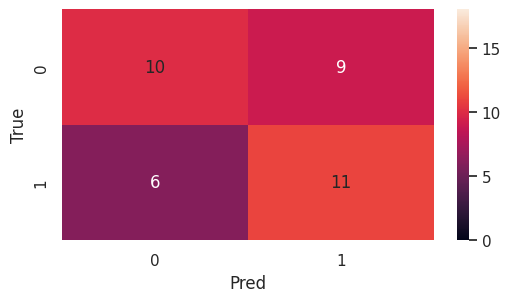

Length of dataset: 36
{'zeroThreshold': 0.19020084934369594, 'sumThreshold': 62.034893624119576, 'lossFn': 'L1', 'gaussianFilterSize': 3, 'gaussianFilterSigma': 3, 'filter': 'MinFilter', 'distinctCAETraining': True, 'cameras': ['NEN1', 'SBU3'], 'balanced': True}
mean pos: 127.0409803390503, std pos: 109.12147755640456
mean neg: 83.86434400709052, std neg: 170.32075970303782
median pos: 120.41159057617188, median neg: 42.287803649902344
lowest pos: 14.860102653503418, highest pos: 422.70306396484375
lowest neg: 1.0588548183441162, highest neg: 788.571533203125
accuracy: 0.6388888888888888
precision: 0.625
recall: 0.5882352941176471
f1: 0.6060606060606061


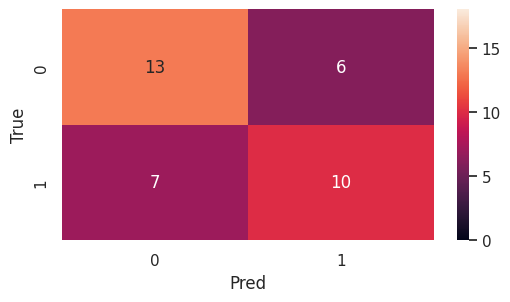

Length of dataset: 36
{'zeroThreshold': 0.17848955717567622, 'sumThreshold': 53.81485972792629, 'lossFn': 'L1', 'gaussianFilterSize': 5, 'gaussianFilterSigma': 3, 'filter': 'MinFilter', 'distinctCAETraining': False, 'cameras': ['NEN1', 'SBU3'], 'balanced': False}
mean pos: 150.45399284362793, std pos: 122.5370971185798
mean neg: 109.54598621318215, std neg: 216.5332884913884
median pos: 134.51377868652344, median neg: 40.316749572753906
lowest pos: 20.550073623657227, highest pos: 492.75616455078125
lowest neg: 1.979926347732544, highest neg: 993.950927734375
accuracy: 0.6388888888888888
precision: 0.5909090909090909
recall: 0.7647058823529411
f1: 0.6666666666666667


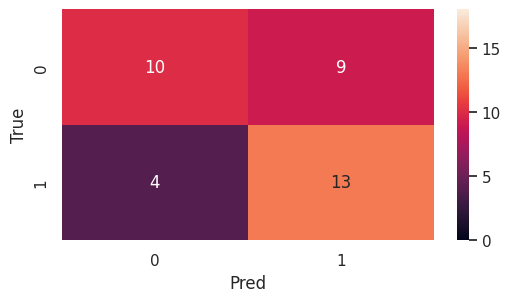

Length of dataset: 36
{'zeroThreshold': 0.27482865263552164, 'sumThreshold': 53.210262429110564, 'lossFn': 'L1', 'gaussianFilterSize': 5, 'gaussianFilterSigma': 3, 'filter': 'MinFilter', 'distinctCAETraining': False, 'cameras': ['NEN1', 'SBU3'], 'balanced': True}
mean pos: 97.88244721468757, std pos: 105.30625655101126
mean neg: 58.01735128227033, std neg: 139.8194422135552
median pos: 76.0495834350586, median neg: 11.113018035888672
lowest pos: 4.067409992218018, highest pos: 434.3833312988281
lowest neg: 0.0, highest neg: 634.7672119140625
accuracy: 0.6388888888888888
precision: 0.6428571428571429
recall: 0.5294117647058824
f1: 0.5806451612903226


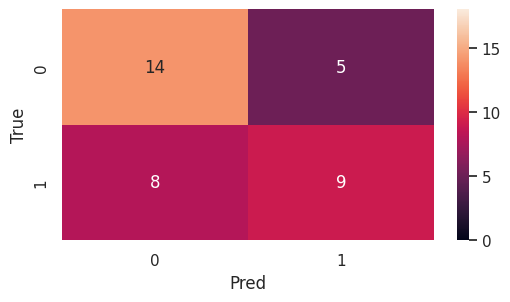

Length of dataset: 36
{'zeroThreshold': 0.19051050835096353, 'sumThreshold': 54.06585430161085, 'lossFn': 'L1', 'gaussianFilterSize': 5, 'gaussianFilterSigma': 3, 'filter': 'MinFilter', 'distinctCAETraining': True, 'cameras': ['NEN1', 'SBU3'], 'balanced': True}
mean pos: 141.2950595406925, std pos: 120.28021440356814
mean neg: 101.04878850987083, std neg: 205.36481627859524
median pos: 124.20762634277344, median neg: 34.2178955078125
lowest pos: 18.353158950805664, highest pos: 485.23919677734375
lowest neg: 1.6035487651824951, highest neg: 940.356201171875
accuracy: 0.6944444444444444
precision: 0.65
recall: 0.7647058823529411
f1: 0.7027027027027027


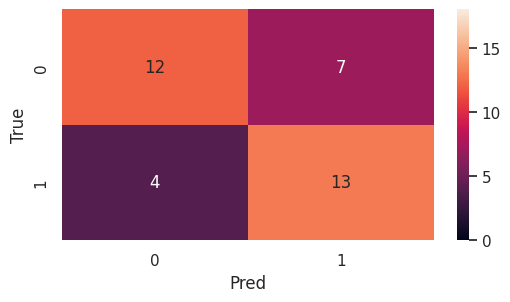

Length of dataset: 36
{'zeroThreshold': 0.19051050835096353, 'sumThreshold': 67.94128356094319, 'lossFn': 'L1', 'gaussianFilterSize': 3, 'gaussianFilterSigma': 3, 'filter': 'MinFilter', 'distinctCAETraining': False, 'cameras': ['NEN1', 'SBU3'], 'balanced': False}
mean pos: 126.87299201067756, std pos: 109.10133804447914
mean neg: 83.82428229482551, std neg: 170.24057370865992
median pos: 120.22116088867188, median neg: 42.09758758544922
lowest pos: 14.860101699829102, highest pos: 422.70306396484375
lowest neg: 1.058854579925537, highest neg: 788.1908569335938
accuracy: 0.6111111111111112
precision: 0.6
recall: 0.5294117647058824
f1: 0.5625


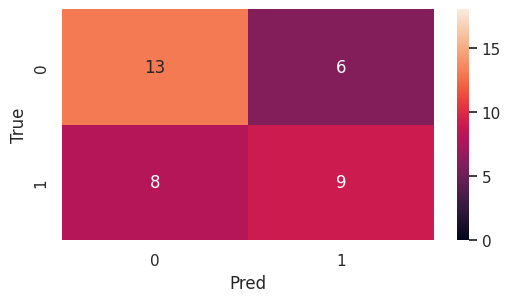

Length of dataset: 36
{'zeroThreshold': 0.23261994775929018, 'sumThreshold': 33.38264647591051, 'lossFn': 'L1', 'gaussianFilterSize': 3, 'gaussianFilterSigma': 3, 'filter': 'MinFilter', 'distinctCAETraining': True, 'cameras': ['NEN1', 'SBU3'], 'balanced': False}
mean pos: 108.22089237325332, std pos: 102.42173067222232
mean neg: 63.60417494020964, std neg: 140.5796931715067
median pos: 97.417236328125, median neg: 25.20928955078125
lowest pos: 7.660876750946045, highest pos: 405.5756530761719
lowest neg: 0.0, highest neg: 646.3760986328125
accuracy: 0.6666666666666666
precision: 0.6190476190476191
recall: 0.7647058823529411
f1: 0.6842105263157895


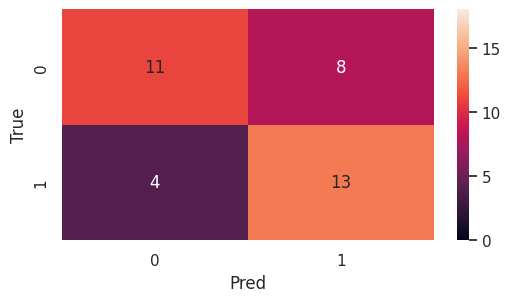

Length of dataset: 36
{'zeroThreshold': 0.37381625098352966, 'sumThreshold': 27.77222303319531, 'lossFn': 'L1', 'gaussianFilterSize': 5, 'gaussianFilterSigma': 5, 'filter': 'MinFilter', 'distinctCAETraining': True, 'cameras': ['NEN1', 'SBU3'], 'balanced': True}
mean pos: 68.89872963112943, std pos: 93.59648878275486
mean neg: 30.913220923197898, std neg: 85.36441097018428
median pos: 37.393333435058594, median neg: 1.1699217557907104
lowest pos: 0.0, highest pos: 395.1689453125
lowest neg: 0.0, highest neg: 387.146240234375
accuracy: 0.7222222222222222
precision: 0.7692307692307693
recall: 0.5882352941176471
f1: 0.6666666666666667


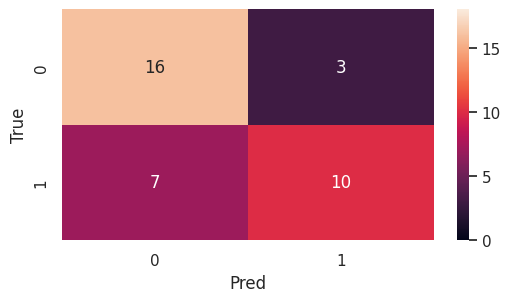

Length of dataset: 36
{'zeroThreshold': 0.32006959992323225, 'sumThreshold': 24.078541708323137, 'lossFn': 'L1', 'gaussianFilterSize': 5, 'gaussianFilterSigma': 3, 'filter': 'MinFilter', 'distinctCAETraining': False, 'cameras': ['NEN1', 'SBU3'], 'balanced': True}
mean pos: 82.90534215113696, std pos: 99.77911005140331
mean neg: 43.66974385788566, std neg: 112.04971805349564
median pos: 48.577396392822266, median neg: 2.8562171459198
lowest pos: 1.40352463722229, highest pos: 417.69879150390625
lowest neg: 0.0, highest neg: 507.8645324707031
accuracy: 0.6666666666666666
precision: 0.631578947368421
recall: 0.7058823529411765
f1: 0.6666666666666667


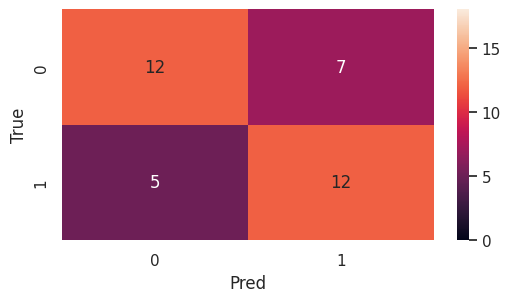

Length of dataset: 36
{'zeroThreshold': 0.3789928342475407, 'sumThreshold': 55.97786683309145, 'lossFn': 'L1', 'gaussianFilterSize': 3, 'gaussianFilterSigma': 3, 'filter': 'MinFilter', 'distinctCAETraining': True, 'cameras': ['NEN1', 'SBU3'], 'balanced': True}
mean pos: 67.05767545279335, std pos: 88.72345074765846
mean neg: 27.347200732482108, std neg: 69.93389545042305
median pos: 35.98796081542969, median neg: 3.895491361618042
lowest pos: 0.8176615238189697, highest pos: 366.34735107421875
lowest neg: 0.0, highest neg: 318.1205749511719
accuracy: 0.6944444444444444
precision: 0.875
recall: 0.4117647058823529
f1: 0.56


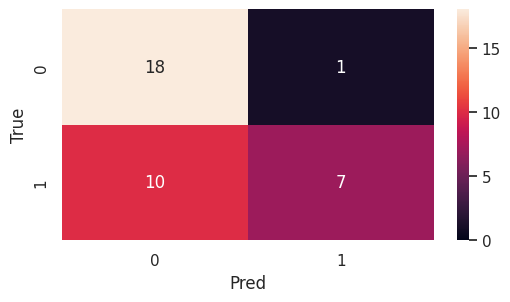

Length of dataset: 36
{'zeroThreshold': 0.19020084934369594, 'sumThreshold': 33.38264647591051, 'lossFn': 'L1', 'gaussianFilterSize': 3, 'gaussianFilterSigma': 3, 'filter': 'MinFilter', 'distinctCAETraining': False, 'cameras': ['NEN1', 'SBU3'], 'balanced': True}
mean pos: 127.04097787071677, std pos: 109.12147590886178
mean neg: 83.86434423923492, std neg: 170.32075974551034
median pos: 120.41159057617188, median neg: 42.287803649902344
lowest pos: 14.860102653503418, highest pos: 422.70306396484375
lowest neg: 1.0588546991348267, highest neg: 788.571533203125
accuracy: 0.6666666666666666
precision: 0.6
recall: 0.8823529411764706
f1: 0.7142857142857143


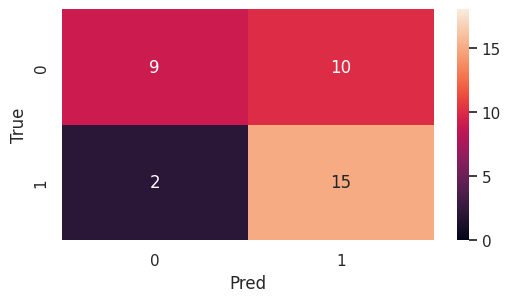

Length of dataset: 36
{'zeroThreshold': 0.24946396406633503, 'sumThreshold': 24.078541708323137, 'lossFn': 'L1', 'gaussianFilterSize': 3, 'gaussianFilterSigma': 3, 'filter': 'MinFilter', 'distinctCAETraining': True, 'cameras': ['NEN1', 'SBU3'], 'balanced': False}
mean pos: 101.65795152327594, std pos: 100.43555561277097
mean neg: 57.082403358660244, std neg: 128.31295386878597
median pos: 86.7842788696289, median neg: 21.194183349609375
lowest pos: 6.929888725280762, highest pos: 399.7918701171875
lowest neg: 0.0, highest neg: 588.4231567382812
accuracy: 0.6666666666666666
precision: 0.6190476190476191
recall: 0.7647058823529411
f1: 0.6842105263157895


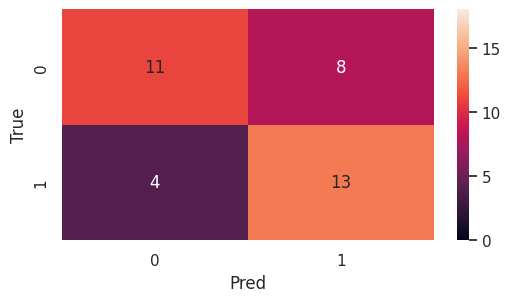

Length of dataset: 36
{'zeroThreshold': 0.34769377653549827, 'sumThreshold': 27.77222303319531, 'lossFn': 'L1', 'gaussianFilterSize': 3, 'gaussianFilterSigma': 3, 'filter': 'MinFilter', 'distinctCAETraining': False, 'cameras': ['NEN1', 'SBU3'], 'balanced': False}
mean pos: 73.51491105556488, std pos: 91.11485361192273
mean neg: 31.85336541815808, std neg: 80.20804713181444
median pos: 43.23074722290039, median neg: 4.980563163757324
lowest pos: 1.1952650547027588, highest pos: 373.9164733886719
lowest neg: 0.0, highest neg: 365.4359130859375
accuracy: 0.6666666666666666
precision: 0.6666666666666666
recall: 0.5882352941176471
f1: 0.625


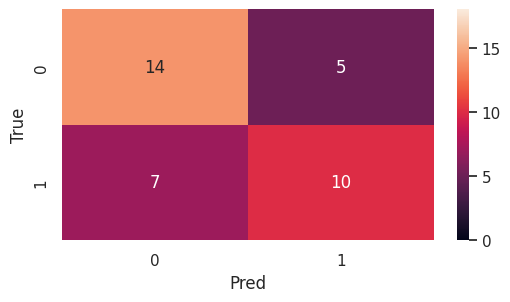

Length of dataset: 36
{'zeroThreshold': 0.2148959860091662, 'sumThreshold': 43.79986331195764, 'lossFn': 'L1', 'gaussianFilterSize': 5, 'gaussianFilterSigma': 5, 'filter': 'MinFilter', 'distinctCAETraining': True, 'cameras': ['NEN1', 'SBU3'], 'balanced': True}
mean pos: 126.49272380155675, std pos: 115.60706794230347
mean neg: 84.6538964258997, std neg: 183.1821748741722
median pos: 110.2181396484375, median neg: 27.19085121154785
lowest pos: 14.630973815917969, highest pos: 469.6845703125
lowest neg: 0.6915760040283203, highest neg: 834.763427734375
accuracy: 0.6666666666666666
precision: 0.631578947368421
recall: 0.7058823529411765
f1: 0.6666666666666667


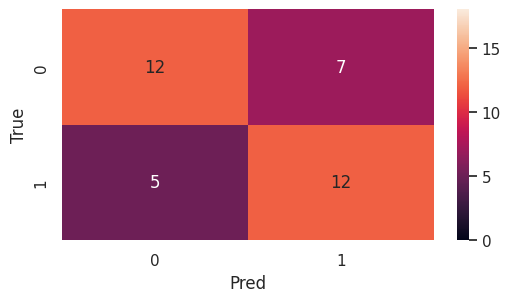

Length of dataset: 36
{'zeroThreshold': 0.3030518027324761, 'sumThreshold': 33.0457914767432, 'lossFn': 'L1', 'gaussianFilterSize': 3, 'gaussianFilterSigma': 5, 'filter': 'MinFilter', 'distinctCAETraining': True, 'cameras': ['NEN1', 'SBU3'], 'balanced': False}
mean pos: 84.60796344981475, std pos: 95.24410193685652
mean neg: 41.3606829878531, std neg: 99.76606347355347
median pos: 55.021934509277344, median neg: 8.3429536819458
lowest pos: 2.131871223449707, highest pos: 386.85247802734375
lowest neg: 0.0, highest neg: 455.4991455078125
accuracy: 0.6388888888888888
precision: 0.625
recall: 0.5882352941176471
f1: 0.6060606060606061


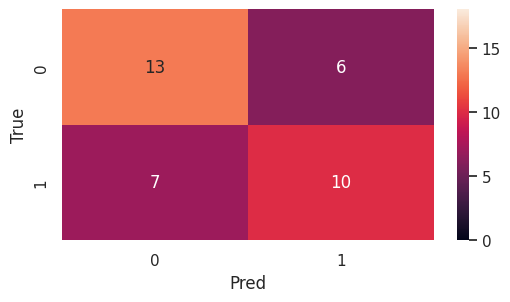

Length of dataset: 36
{'zeroThreshold': 0.3821725663016331, 'sumThreshold': 52.157880574840604, 'lossFn': 'L1', 'gaussianFilterSize': 5, 'gaussianFilterSigma': 3, 'filter': 'MinFilter', 'distinctCAETraining': False, 'cameras': ['NEN1', 'SBU3'], 'balanced': True}
mean pos: 67.4534681965323, std pos: 92.22386472856046
mean neg: 29.626207439522993, std neg: 82.40148432408141
median pos: 34.89555358886719, median neg: 0.8208048939704895
lowest pos: 0.0, highest pos: 389.7142639160156
lowest neg: 0.0, highest neg: 373.9737548828125
accuracy: 0.6666666666666666
precision: 0.7777777777777778
recall: 0.4117647058823529
f1: 0.5384615384615384


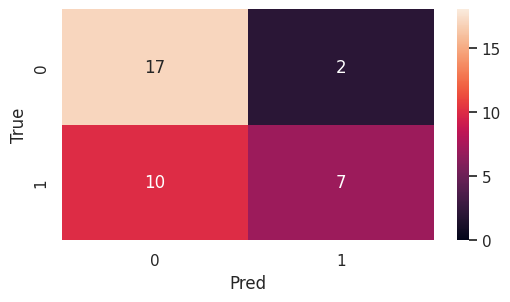

Length of dataset: 36
{'zeroThreshold': 0.3030518027324761, 'sumThreshold': 52.157880574840604, 'lossFn': 'L1', 'gaussianFilterSize': 5, 'gaussianFilterSigma': 3, 'filter': 'MinFilter', 'distinctCAETraining': False, 'cameras': ['NEN1', 'SBU3'], 'balanced': True}
mean pos: 88.21326805563534, std pos: 101.34627576317105
mean neg: 48.577475543084894, std neg: 121.93052664522993
median pos: 57.27088928222656, median neg: 5.653861999511719
lowest pos: 1.40352463722229, highest pos: 421.43170166015625
lowest neg: 0.0, highest neg: 552.8890380859375
accuracy: 0.7222222222222222
precision: 0.8181818181818182
recall: 0.5294117647058824
f1: 0.6428571428571428


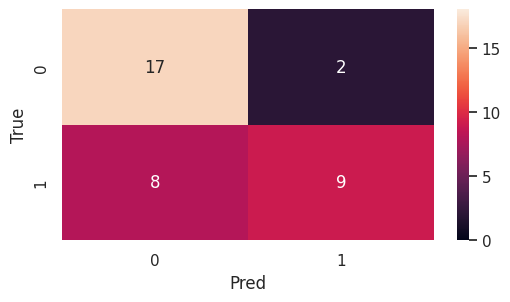

Length of dataset: 36
{'zeroThreshold': 0.37381625098352966, 'sumThreshold': 37.795137807209585, 'lossFn': 'L1', 'gaussianFilterSize': 3, 'gaussianFilterSigma': 5, 'filter': 'MinFilter', 'distinctCAETraining': False, 'cameras': ['NEN1', 'SBU3'], 'balanced': False}
mean pos: 68.22990672027363, std pos: 89.16866778813187
mean neg: 28.17144289142207, std neg: 72.51522484553435
median pos: 36.35264587402344, median neg: 3.8667726516723633
lowest pos: 1.1978611946105957, highest pos: 367.5103759765625
lowest neg: 0.0, highest neg: 329.9630126953125
accuracy: 0.6944444444444444
precision: 0.8
recall: 0.47058823529411764
f1: 0.5925925925925927


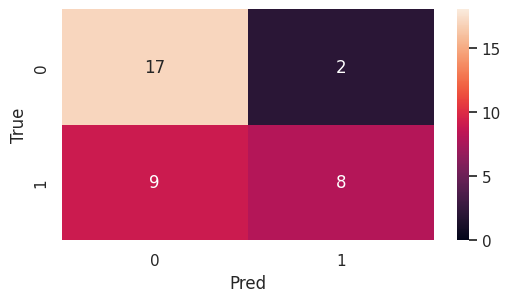

Length of dataset: 36
{'zeroThreshold': 0.17848955717567622, 'sumThreshold': 46.91305835750245, 'lossFn': 'L1', 'gaussianFilterSize': 5, 'gaussianFilterSigma': 5, 'filter': 'MinFilter', 'distinctCAETraining': True, 'cameras': ['NEN1', 'SBU3'], 'balanced': True}
mean pos: 150.08514696009019, std pos: 122.7869020423406
mean neg: 109.12092338110271, std neg: 216.37718702528542
median pos: 134.7587890625, median neg: 39.02126693725586
lowest pos: 20.501827239990234, highest pos: 495.54302978515625
lowest neg: 1.8394062519073486, highest neg: 992.4953002929688
accuracy: 0.6666666666666666
precision: 0.6086956521739131
recall: 0.8235294117647058
f1: 0.7


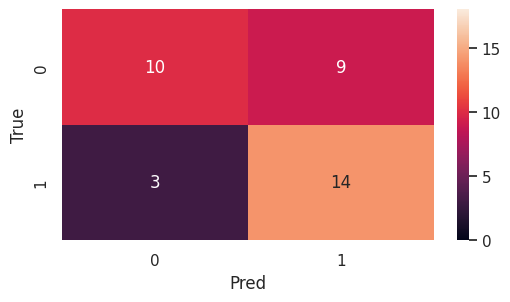

Length of dataset: 36
{'zeroThreshold': 0.3821725663016331, 'sumThreshold': 53.210262429110564, 'lossFn': 'L1', 'gaussianFilterSize': 3, 'gaussianFilterSigma': 5, 'filter': 'MinFilter', 'distinctCAETraining': True, 'cameras': ['NEN1', 'SBU3'], 'balanced': True}
mean pos: 66.31798387275023, std pos: 88.5762556963163
mean neg: 26.93762647478204, std neg: 69.46936742549772
median pos: 35.974491119384766, median neg: 3.7296533584594727
lowest pos: 0.43741679191589355, highest pos: 365.988525390625
lowest neg: 0.0, highest neg: 315.9842529296875
accuracy: 0.6944444444444444
precision: 0.875
recall: 0.4117647058823529
f1: 0.56


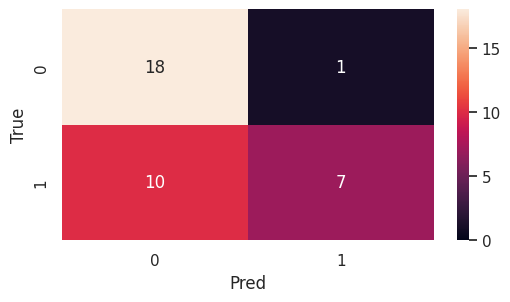

Length of dataset: 36
{'zeroThreshold': 0.1568802095920743, 'sumThreshold': 42.45089867618973, 'lossFn': 'L1', 'gaussianFilterSize': 5, 'gaussianFilterSigma': 3, 'filter': 'MinFilter', 'distinctCAETraining': True, 'cameras': ['NEN1', 'SBU3'], 'balanced': False}
mean pos: 167.96398230159983, std pos: 128.6101933895765
mean neg: 128.5773904323578, std neg: 237.61036194027318
median pos: 155.09823608398438, median neg: 59.15818405151367
lowest pos: 25.425891876220703, highest pos: 511.3839416503906
lowest neg: 3.4512059688568115, highest neg: 1096.057373046875
accuracy: 0.6666666666666666
precision: 0.5925925925925926
recall: 0.9411764705882353
f1: 0.7272727272727272


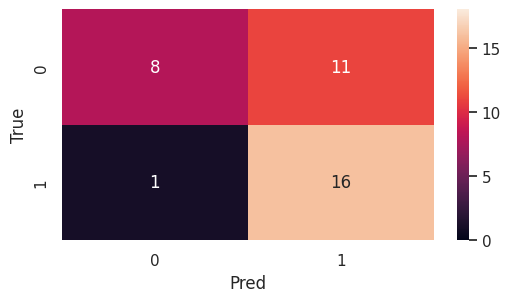

Length of dataset: 36
{'zeroThreshold': 0.17848955717567622, 'sumThreshold': 25.44874020537303, 'lossFn': 'L1', 'gaussianFilterSize': 5, 'gaussianFilterSigma': 5, 'filter': 'MinFilter', 'distinctCAETraining': True, 'cameras': ['NEN1', 'SBU3'], 'balanced': True}
mean pos: 150.08514606251435, std pos: 122.78690158741301
mean neg: 109.12092626722236, std neg: 216.37720011683484
median pos: 134.7587890625, median neg: 39.02126693725586
lowest pos: 20.501827239990234, highest pos: 495.54302978515625
lowest neg: 1.839406132698059, highest neg: 992.495361328125
accuracy: 0.6388888888888888
precision: 0.5714285714285714
recall: 0.9411764705882353
f1: 0.7111111111111111


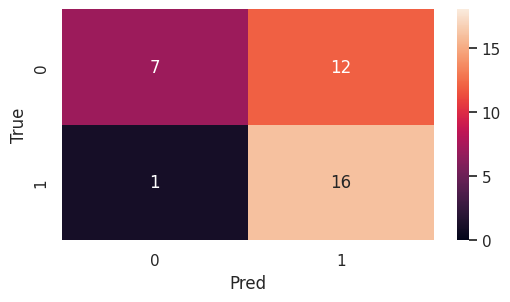

Length of dataset: 36
{'zeroThreshold': 0.3789928342475407, 'sumThreshold': 46.91305835750245, 'lossFn': 'L1', 'gaussianFilterSize': 5, 'gaussianFilterSigma': 3, 'filter': 'MinFilter', 'distinctCAETraining': False, 'cameras': ['NEN1', 'SBU3'], 'balanced': True}
mean pos: 68.25892179152545, std pos: 92.77677014819015
mean neg: 30.207252358135424, std neg: 83.35179619389983
median pos: 35.65657043457031, median neg: 1.1859418153762817
lowest pos: 0.0, highest pos: 391.236572265625
lowest neg: 0.0, highest neg: 378.158935546875
accuracy: 0.6666666666666666
precision: 0.7777777777777778
recall: 0.4117647058823529
f1: 0.5384615384615384


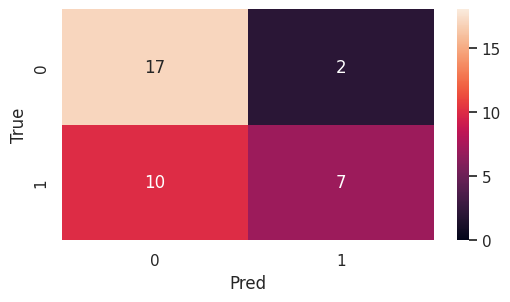

Length of dataset: 36
{'zeroThreshold': 0.2047068618842173, 'sumThreshold': 52.157880574840604, 'lossFn': 'L1', 'gaussianFilterSize': 3, 'gaussianFilterSigma': 3, 'filter': 'MinFilter', 'distinctCAETraining': True, 'cameras': ['NEN1', 'SBU3'], 'balanced': False}
mean pos: 119.61501373964198, std pos: 106.87683065397277
mean neg: 75.79716410762386, std neg: 158.9479377623908
median pos: 111.56942749023438, median neg: 36.825599670410156
lowest pos: 12.242527961730957, highest pos: 416.9564208984375
lowest neg: 0.6611045598983765, highest neg: 733.7965087890625
accuracy: 0.6388888888888888
precision: 0.625
recall: 0.5882352941176471
f1: 0.6060606060606061


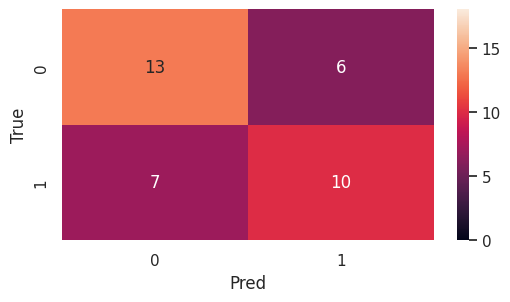

Length of dataset: 36
{'zeroThreshold': 0.27482865263552164, 'sumThreshold': 46.91305835750245, 'lossFn': 'L1', 'gaussianFilterSize': 5, 'gaussianFilterSigma': 5, 'filter': 'MinFilter', 'distinctCAETraining': False, 'cameras': ['NEN1', 'SBU3'], 'balanced': True}
mean pos: 97.52696889989517, std pos: 105.54163020707473
mean neg: 57.60293038581547, std neg: 139.42098297919483
median pos: 76.5940170288086, median neg: 10.476670265197754
lowest pos: 4.083065032958984, highest pos: 436.1824951171875
lowest neg: 0.0, highest neg: 632.847900390625
accuracy: 0.6388888888888888
precision: 0.6428571428571429
recall: 0.5294117647058824
f1: 0.5806451612903226


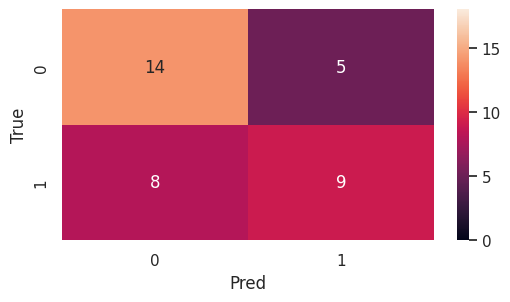

Length of dataset: 36
{'zeroThreshold': 0.17848955717567622, 'sumThreshold': 24.078541708323137, 'lossFn': 'L1', 'gaussianFilterSize': 3, 'gaussianFilterSigma': 3, 'filter': 'MinFilter', 'distinctCAETraining': True, 'cameras': ['NEN1', 'SBU3'], 'balanced': True}
mean pos: 134.02809468437644, std pos: 111.3396616920895
mean neg: 90.70311662397887, std neg: 178.83225348668165
median pos: 128.5382080078125, median neg: 47.809757232666016
lowest pos: 16.15033531188965, highest pos: 428.25201416015625
lowest neg: 1.789162278175354, highest neg: 829.9791259765625
accuracy: 0.6111111111111112
precision: 0.5555555555555556
recall: 0.8823529411764706
f1: 0.6818181818181819


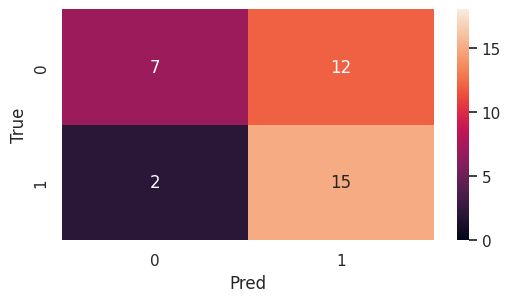

Length of dataset: 36
{'zeroThreshold': 0.2811186432289918, 'sumThreshold': 54.06585430161085, 'lossFn': 'L1', 'gaussianFilterSize': 3, 'gaussianFilterSigma': 3, 'filter': 'MinFilter', 'distinctCAETraining': False, 'cameras': ['NEN1', 'SBU3'], 'balanced': False}
mean pos: 90.72375133458306, std pos: 97.70499415300775
mean neg: 46.880009968029825, std neg: 109.62061264528066
median pos: 66.69412231445312, median neg: 13.686698913574219
lowest pos: 2.426889181137085, highest pos: 393.45098876953125
lowest neg: 0.0, highest neg: 501.47259521484375
accuracy: 0.7222222222222222
precision: 0.8181818181818182
recall: 0.5294117647058824
f1: 0.6428571428571428


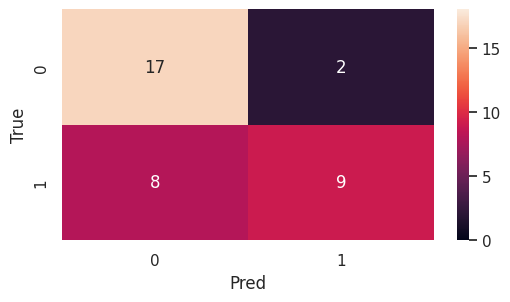

Length of dataset: 36
{'zeroThreshold': 0.22504841790445454, 'sumThreshold': 37.795137807209585, 'lossFn': 'L1', 'gaussianFilterSize': 5, 'gaussianFilterSigma': 3, 'filter': 'MinFilter', 'distinctCAETraining': True, 'cameras': ['NEN1', 'SBU3'], 'balanced': False}
mean pos: 121.03708250382367, std pos: 114.1835030560333
mean neg: 79.30126799878322, std neg: 174.26784991118137
median pos: 105.62937927246094, median neg: 24.916807174682617
lowest pos: 11.96120548248291, highest pos: 464.41888427734375
lowest neg: 0.2367440164089203, highest neg: 793.419921875
accuracy: 0.6944444444444444
precision: 0.6363636363636364
recall: 0.8235294117647058
f1: 0.717948717948718


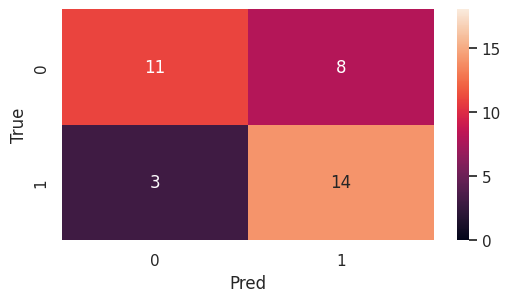

Length of dataset: 36
{'zeroThreshold': 0.28038951133506756, 'sumThreshold': 42.45089867618973, 'lossFn': 'L1', 'gaussianFilterSize': 5, 'gaussianFilterSigma': 5, 'filter': 'MinFilter', 'distinctCAETraining': True, 'cameras': ['NEN1', 'SBU3'], 'balanced': True}
mean pos: 95.50166696660659, std pos: 104.3240111988576
mean neg: 55.52904773072193, std neg: 135.50740953396422
median pos: 72.15360260009766, median neg: 10.196967124938965
lowest pos: 4.028694152832031, highest pos: 432.55657958984375
lowest neg: 0.0, highest neg: 615.0861206054688
accuracy: 0.6666666666666666
precision: 0.6666666666666666
recall: 0.5882352941176471
f1: 0.625


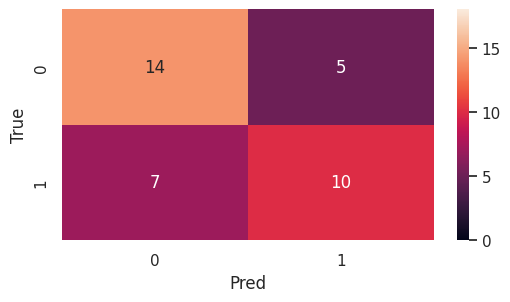

Length of dataset: 36
{'zeroThreshold': 0.1871767878614525, 'sumThreshold': 43.79986331195764, 'lossFn': 'L1', 'gaussianFilterSize': 3, 'gaussianFilterSigma': 3, 'filter': 'MinFilter', 'distinctCAETraining': True, 'cameras': ['NEN1', 'SBU3'], 'balanced': True}
mean pos: 128.7290990492877, std pos: 109.78538126626184
mean neg: 85.47245179979424, std neg: 172.52397798492476
median pos: 121.92032623291016, median neg: 43.4180793762207
lowest pos: 14.860101699829102, highest pos: 425.34149169921875
lowest neg: 1.247309923171997, highest neg: 799.13427734375
accuracy: 0.6666666666666666
precision: 0.6086956521739131
recall: 0.8235294117647058
f1: 0.7


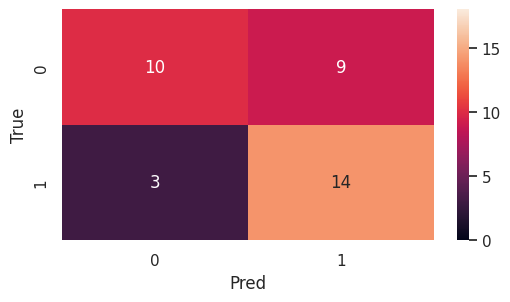

/tmp/ipykernel_503004/2513508341.py:105: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar([i-0.1 for i in range(len(posVals["mean"]))], posVals["mean"], yerr=posVals["std"],fmt='.k', capsize=5, label="pos (mean and std)", color="tomato")
/tmp/ipykernel_503004/2513508341.py:106: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar([i+0.1 for i in range(len(negVals["mean"]))], negVals["mean"], yerr=negVals["std"],fmt='.k', capsize=5, label="neg (mean and std)", color="cornflowerblue")


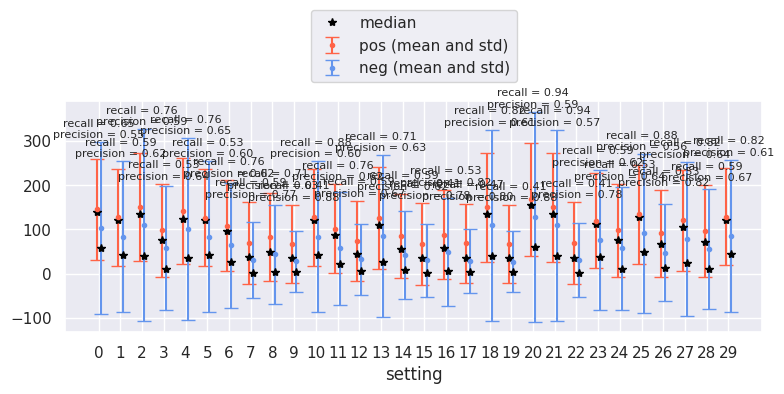

In [50]:
evaluateAndPlotSettings(sampler)

Length of dataset: 36
{'zeroThreshold': 0.1615172777593626, 'sumThreshold': 62.477666679021944, 'lossFn': 'L1', 'gaussianFilterSize': 3, 'gaussianFilterSigma': 5, 'filter': 'MinFilter', 'distinctCAETraining': False, 'cameras': ['NEN1', 'SBU3'], 'balanced': False}
mean pos: 145.01818241792566, std pos: 114.9220298407247
mean neg: 102.72875720576236, std neg: 194.60596006249833
median pos: 139.24081420898438, median neg: 58.229644775390625
lowest pos: 18.690746307373047, highest pos: 439.0312805175781
lowest neg: 3.1442418098449707, highest neg: 906.038330078125
accuracy: 0.5833333333333334
precision: 0.55
recall: 0.6470588235294118
f1: 0.5945945945945946


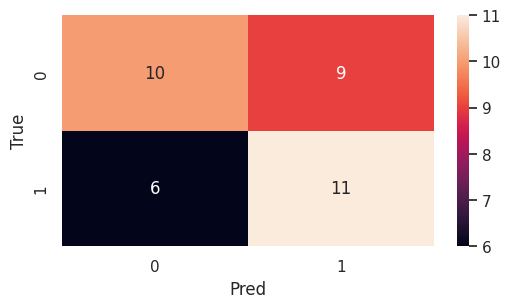

Length of dataset: 36
{'zeroThreshold': 0.19020084934369594, 'sumThreshold': 62.034893624119576, 'lossFn': 'L1', 'gaussianFilterSize': 3, 'gaussianFilterSigma': 3, 'filter': 'MinFilter', 'distinctCAETraining': True, 'cameras': ['NEN1', 'SBU3'], 'balanced': True}
mean pos: 127.04097674874698, std pos: 109.12147674727836
mean neg: 83.86434380631698, std neg: 170.3207598070023
median pos: 120.41159057617188, median neg: 42.287803649902344
lowest pos: 14.860102653503418, highest pos: 422.70306396484375
lowest neg: 1.0588548183441162, highest neg: 788.571533203125
accuracy: 0.6388888888888888
precision: 0.625
recall: 0.5882352941176471
f1: 0.6060606060606061


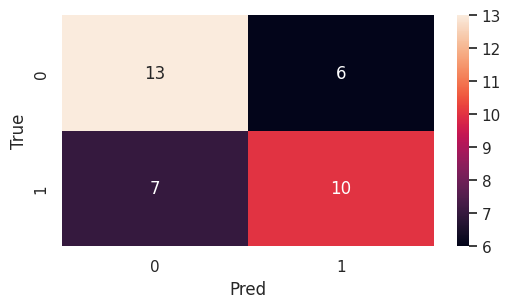

Length of dataset: 36
{'zeroThreshold': 0.17848955717567622, 'sumThreshold': 53.81485972792629, 'lossFn': 'L1', 'gaussianFilterSize': 5, 'gaussianFilterSigma': 3, 'filter': 'MinFilter', 'distinctCAETraining': False, 'cameras': ['NEN1', 'SBU3'], 'balanced': False}
mean pos: 150.45399385340073, std pos: 122.5371005966425
mean neg: 109.5459851967661, std neg: 216.5332883770139
median pos: 134.51377868652344, median neg: 40.316749572753906
lowest pos: 20.550073623657227, highest pos: 492.75616455078125
lowest neg: 1.979926347732544, highest neg: 993.950927734375
accuracy: 0.6388888888888888
precision: 0.5909090909090909
recall: 0.7647058823529411
f1: 0.6666666666666667


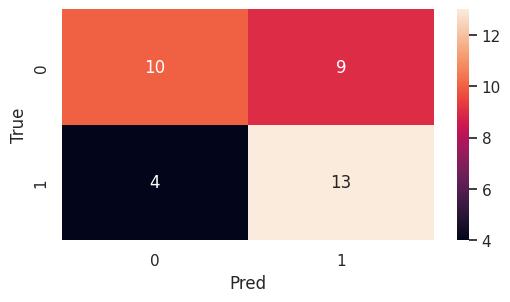

Length of dataset: 36
{'zeroThreshold': 0.27482865263552164, 'sumThreshold': 53.210262429110564, 'lossFn': 'L1', 'gaussianFilterSize': 5, 'gaussianFilterSigma': 3, 'filter': 'MinFilter', 'distinctCAETraining': False, 'cameras': ['NEN1', 'SBU3'], 'balanced': True}
mean pos: 97.88245038425221, std pos: 105.30625901809854
mean neg: 58.01735096542459, std neg: 139.8194422868902
median pos: 76.04959106445312, median neg: 11.113016128540039
lowest pos: 4.067409992218018, highest pos: 434.3833312988281
lowest neg: 0.0, highest neg: 634.7672119140625
accuracy: 0.6388888888888888
precision: 0.6428571428571429
recall: 0.5294117647058824
f1: 0.5806451612903226


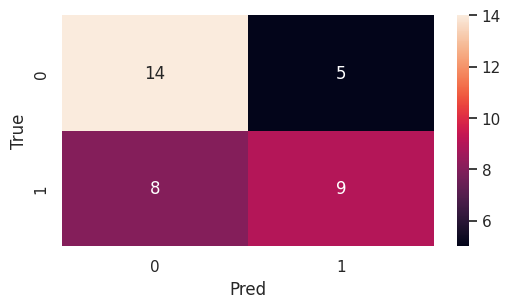

Length of dataset: 36
{'zeroThreshold': 0.19051050835096353, 'sumThreshold': 54.06585430161085, 'lossFn': 'L1', 'gaussianFilterSize': 5, 'gaussianFilterSigma': 3, 'filter': 'MinFilter', 'distinctCAETraining': True, 'cameras': ['NEN1', 'SBU3'], 'balanced': True}
mean pos: 141.29505920410156, std pos: 120.2802146848806
mean neg: 101.04878824008138, std neg: 205.3648163555465
median pos: 124.20762634277344, median neg: 34.2178955078125
lowest pos: 18.353158950805664, highest pos: 485.23919677734375
lowest neg: 1.6035487651824951, highest neg: 940.356201171875
accuracy: 0.6944444444444444
precision: 0.65
recall: 0.7647058823529411
f1: 0.7027027027027027


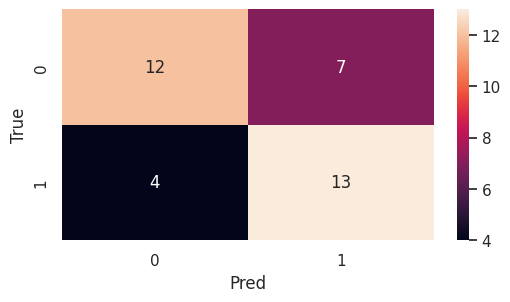

Length of dataset: 36
{'zeroThreshold': 0.19051050835096353, 'sumThreshold': 67.94128356094319, 'lossFn': 'L1', 'gaussianFilterSize': 3, 'gaussianFilterSigma': 3, 'filter': 'MinFilter', 'distinctCAETraining': False, 'cameras': ['NEN1', 'SBU3'], 'balanced': False}
mean pos: 126.8729897106395, std pos: 109.10133701437648
mean neg: 83.82428184308503, std neg: 170.2405738295285
median pos: 120.22116088867188, median neg: 42.09758758544922
lowest pos: 14.860102653503418, highest pos: 422.70306396484375
lowest neg: 1.0588548183441162, highest neg: 788.1908569335938
accuracy: 0.6111111111111112
precision: 0.6
recall: 0.5294117647058824
f1: 0.5625


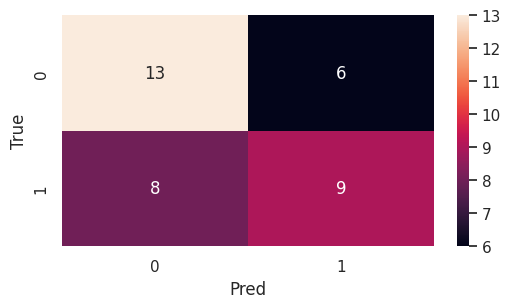

Length of dataset: 36
{'zeroThreshold': 0.23261994775929018, 'sumThreshold': 33.38264647591051, 'lossFn': 'L1', 'gaussianFilterSize': 3, 'gaussianFilterSigma': 3, 'filter': 'MinFilter', 'distinctCAETraining': True, 'cameras': ['NEN1', 'SBU3'], 'balanced': False}
mean pos: 108.22089270984425, std pos: 102.4217307923881
mean neg: 63.60417534175672, std neg: 140.57969316407642
median pos: 97.417236328125, median neg: 25.20928955078125
lowest pos: 7.660876750946045, highest pos: 405.5756530761719
lowest neg: 0.0, highest neg: 646.3760986328125
accuracy: 0.6666666666666666
precision: 0.6190476190476191
recall: 0.7647058823529411
f1: 0.6842105263157895


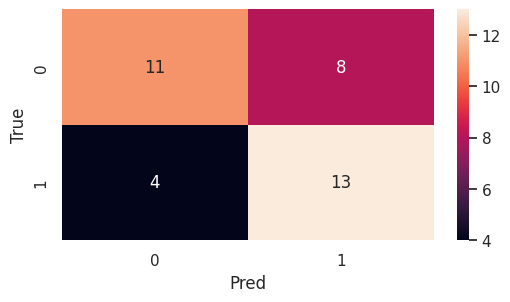

Length of dataset: 36
{'zeroThreshold': 0.37381625098352966, 'sumThreshold': 27.77222303319531, 'lossFn': 'L1', 'gaussianFilterSize': 5, 'gaussianFilterSigma': 5, 'filter': 'MinFilter', 'distinctCAETraining': True, 'cameras': ['NEN1', 'SBU3'], 'balanced': True}
mean pos: 68.8987303043113, std pos: 93.59648882400494
mean neg: 30.91322093888333, std neg: 85.36441096470487
median pos: 37.39333724975586, median neg: 1.1699219942092896
lowest pos: 0.0, highest pos: 395.1689453125
lowest neg: 0.0, highest neg: 387.146240234375
accuracy: 0.7222222222222222
precision: 0.7692307692307693
recall: 0.5882352941176471
f1: 0.6666666666666667


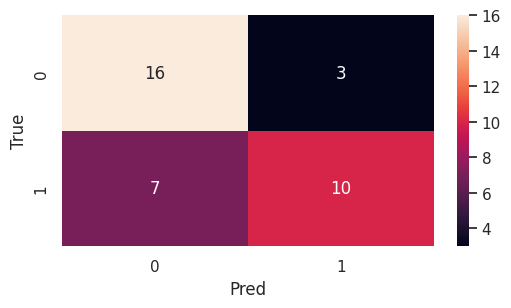

Length of dataset: 36
{'zeroThreshold': 0.32006959992323225, 'sumThreshold': 24.078541708323137, 'lossFn': 'L1', 'gaussianFilterSize': 5, 'gaussianFilterSigma': 3, 'filter': 'MinFilter', 'distinctCAETraining': False, 'cameras': ['NEN1', 'SBU3'], 'balanced': True}
mean pos: 82.9053424316294, std pos: 99.77910993373328
mean neg: 43.66974375749889, std neg: 112.04971806875365
median pos: 48.577396392822266, median neg: 2.8562171459198
lowest pos: 1.40352463722229, highest pos: 417.69879150390625
lowest neg: 0.0, highest neg: 507.8645324707031
accuracy: 0.6666666666666666
precision: 0.631578947368421
recall: 0.7058823529411765
f1: 0.6666666666666667


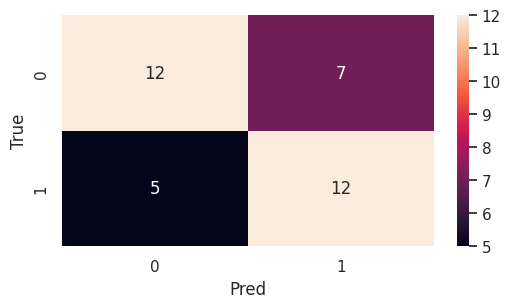

Length of dataset: 36
{'zeroThreshold': 0.3789928342475407, 'sumThreshold': 55.97786683309145, 'lossFn': 'L1', 'gaussianFilterSize': 3, 'gaussianFilterSigma': 3, 'filter': 'MinFilter', 'distinctCAETraining': True, 'cameras': ['NEN1', 'SBU3'], 'balanced': True}


KeyboardInterrupt: 

In [47]:
#TODO: include camerProps

# confMat = ConfusionMatrix(task="binary", num_classes=2)
unnorm = UnNormalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))

negVals = {
    "mean": [],
    "std": [],
    "min": [],
    "max": [],
    "median": []
}
posVals = {
    "mean": [],
    "std": [],
    "min": [],
    "max": [],
    "median": []
}

for params in sampler:
    dataset = DatasetThreeConsecutive(cameras=params["cameras"], resize_to=CAEV1.imsize, **loaderParams)
    print(f'Length of dataset: {len(dataset)}')
    print(params)
    dataLoader = DataLoader(dataset, batch_size=8, shuffle=False, num_workers=2)

    blur = GaussianBlur(kernel_size=params["gaussianFilterSize"], sigma=params["gaussianFilterSigma"]) #TODO: make this a parameter
    lossFn = F.mse_loss if params["lossFn"] == "MSE" else F.l1_loss
    vals = []

    for (imArr, lblArr, camera, ImagePath) in dataLoader:
        isTrainingCamera = camera in caeLoaded.hparams.cameras
        prevImg = imArr[0] #alwasy #batch_size images
        currImg = imArr[1]
        nextImg = imArr[2]

        prevPred, currPred, nextPred = [unnorm(caeLoaded(x.to(caeLoaded.device))) for x in [prevImg, currImg, nextImg]]
        prevImg, currImg, nextImg = [unnorm(x) for x in [prevImg, currImg, nextImg]]

        # plt.imshow(currImg[0].cpu().detach().numpy().transpose(1, 2, 0))
        # plt.show()

        prevImgBlurred, currImgBlurred, nextImgBlurred = [blur.forward(x).to(prevPred.device) for x in [prevImg, currImg, nextImg]]
        # plt.imshow(currImgBlurred[0].cpu().detach().numpy().transpose(1, 2, 0))
        # plt.show()
        
        prevImd, currImd, nextImd = [torch.sum(lossFn(imgBlurred, pred, reduction='none'), dim=1) for imgBlurred, pred in zip([prevImgBlurred, currImgBlurred, nextImgBlurred], [prevPred, currPred, nextPred])]

        prevToCurrImd = torch.clamp(torch.sub(currImd, prevImd), min= 0)
        nextToCurrImd = torch.clamp(torch.sub(currImd, nextImd), min= 0)

        prevNextCurrImd = torch.div(torch.add(prevToCurrImd, nextToCurrImd), 2.0)
        # print(f'min: {torch.min(prevNextCurrImd).item()}')

        prevNextCurrImdMin = torch.stack([min_filter(x, kernel_size=3) for x in prevNextCurrImd])
        

        # plt.imshow(prevNextCurrImdMin[0].cpu().detach().numpy(), cmap="hot")
        # print(torch.sum(prevNextCurrImdMin[0]).item())
        # plt.show()
        # plt.imshow(prevNextCurrImdMin[1].cpu().detach().numpy(), cmap="hot")
        # print(torch.sum(prevNextCurrImdMin[1]).item())
        # plt.show()

        # prevNextCurrImdMin = torch.div(prevNextCurrImdMin, 255)
        # plt.imshow(prevNextCurrImdMin[0].cpu().detach().numpy(), cmap="hot")
        # plt.show()

        # print(torch.max(prevNextCurrImdMin))
        prevNextCurrImdMinThresh = torch.where(prevNextCurrImdMin < params["zeroThreshold"], torch.zeros_like(prevNextCurrImdMin), prevNextCurrImdMin)
        # plt.imshow(prevNextCurrImdMinThresh[0].cpu().detach().numpy(), cmap="hot")
        # plt.show()
        # print(f'min: {torch.min(prevNextCurrImdMinThresh).item()}')
        sumPrevNextCurrImdMin = torch.sum(prevNextCurrImdMinThresh, dim=(1, 2))
        predictions = (sumPrevNextCurrImdMin> params["sumThreshold"]).to(torch.int)


        for i in range(len(predictions)):
            vals.append([lblArr[i].item(), predictions[i].item(), sumPrevNextCurrImdMin[i].item()])
        #     dfNew = pd.DataFrame(columns=columns, )
        #     dfNew = df.append(dict(zip(columns, [lblArr[i].item(), predictions[i].item(), ImagePath[i], includeCameraProps, checkPoint, isTrainingCamera] + list(loaderParams.values()) + list(params.values()))), ignore_index=True)
        
        # df.to_csv(f"/data/tim/heronWorkspace/caeTestData/{fileName}.csv", index=False)

        # print(predictions)
        # print(prevNextCurrImdMin.shape)
        # print(torch.max(prevNextCurrImdMin))
        # print(imArr[0].shape)
        # print(len(imArr))
        # print(len(lblArr))

    # confMat
    vals = np.array(vals)
    # print(vals)
    # print(vals[:, 0])
    # print(vals[:, 1])
    confMat = confusion_matrix(vals[:, 0], vals[:,1])
    fig= plt.figure(figsize = (6,3))
    ax = fig.add_subplot(111)
    sns.heatmap(confMat, annot=True)
    ax.set_xlabel('Pred', fontsize=12)
    ax.set_ylabel('True', fontsize=12)
    onlyPos = vals[vals[:, 0] == 1]
    onlyNeg = vals[vals[:, 0] == 0]
    print(f'mean pos: {np.mean(onlyPos[:, 2])}, std pos: {np.std(onlyPos[:, 2])}')
    print(f'mean neg: {np.mean(onlyNeg[:, 2])}, std neg: {np.std(onlyNeg[:, 2])}')
    print(f'median pos: {np.median(onlyPos[:, 2])}, median neg: {np.median(onlyNeg[:, 2])}')
    print(f'lowest pos: {np.min(onlyPos[:, 2])}, highest pos: {np.max(onlyPos[:, 2])}')
    print(f'lowest neg: {np.min(onlyNeg[:, 2])}, highest neg: {np.max(onlyNeg[:, 2])}')

    posVals["mean"].append(np.mean(onlyPos[:, 2]))
    posVals["std"].append(np.std(onlyPos[:, 2]))
    posVals["min"].append(np.min(onlyPos[:, 2]))
    posVals["max"].append(np.max(onlyPos[:, 2]))
    posVals["median"].append(np.median(onlyPos[:, 2]))

    negVals["mean"].append(np.mean(onlyNeg[:, 2]))
    negVals["std"].append(np.std(onlyNeg[:, 2]))
    negVals["min"].append(np.min(onlyNeg[:, 2]))
    negVals["max"].append(np.max(onlyNeg[:, 2]))
    negVals["median"].append(np.median(onlyNeg[:, 2]))

    print(f'accuracy: {accuracy_score(vals[:, 0], vals[:,1])}')
    print(f'precision: {precision_score(vals[:, 0], vals[:,1])}')
    print(f'recall: {recall_score(vals[:, 0], vals[:,1])}')
    print(f'f1: {f1_score(vals[:, 0], vals[:,1])}')
    plt.show()
    vals = []


fig = plt.figure(figsize = (len(params),3))
plt.errorbar([i-0.1 for i in range(len(posVals["mean"]))], posVals["mean"], yerr=posVals["std"],fmt='.k', capsize=5, label="pos (mean and std)", color="tomato")
plt.errorbar([i+0.1 for i in range(len(negVals["mean"]))], negVals["mean"], yerr=negVals["std"],fmt='.k', capsize=5, label="neg (mean and std)", color="cornflowerblue")
plt.plot([i-0.1 for i in range(len(posVals["mean"]))], posVals["median"], '*', color="black", label="median")
plt.plot([i+0.1 for i in range(len(negVals["mean"]))], negVals["median"], '*', color="black")

plt.xticks(range(len(sampler)))
plt.xlabel("setting")
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05))
plt.show()

# confusionMatrix
# confMat = confusion_matrix(df["trueLbl"], df["predictedLbl"])
# plt.figure(figsize = (6,3))
# sns.heatmap(confMat, annot=True)
# plt.show()

# Evalution of different params

only change one param at once and plot the behaviour (error plot)

In [49]:
#TODO: include camerProps

def evaluateAndPlotSettings(settings: [dict]):
    unnorm = UnNormalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    negVals = {
            "mean": [],
            "std": [],
            "min": [],
            "max": [],
            "median": []
        }
    posVals = {
        "mean": [],
        "std": [],
        "min": [],
        "max": [],
        "median": []
    }
    recallArr = []
    precisionArr = []
    for params in settings:
        dataset = DatasetThreeConsecutive(cameras=params["cameras"], resize_to=CAEV1.imsize, **loaderParams)
        print(f'Length of dataset: {len(dataset)}')
        print(params)
        dataLoader = DataLoader(dataset, batch_size=8, shuffle=False, num_workers=2)

        blur = GaussianBlur(kernel_size=params["gaussianFilterSize"], sigma=params["gaussianFilterSigma"]) #TODO: make this a parameter
        lossFn = F.mse_loss if params["lossFn"] == "MSE" else F.l1_loss
        vals = []
        for (imArr, lblArr, camera, ImagePath) in dataLoader:
            isTrainingCamera = camera in caeLoaded.hparams.cameras
            prevImg = imArr[0] #alwasy #batch_size images
            currImg = imArr[1]
            nextImg = imArr[2]

            prevPred, currPred, nextPred = [unnorm(caeLoaded(x.to(caeLoaded.device))) for x in [prevImg, currImg, nextImg]]
            prevImg, currImg, nextImg = [unnorm(x) for x in [prevImg, currImg, nextImg]]


            prevImgBlurred, currImgBlurred, nextImgBlurred = [blur.forward(x).to(prevPred.device) for x in [prevImg, currImg, nextImg]]
        
            
            prevImd, currImd, nextImd = [torch.sum(lossFn(imgBlurred, pred, reduction='none'), dim=1) for imgBlurred, pred in zip([prevImgBlurred, currImgBlurred, nextImgBlurred], [prevPred, currPred, nextPred])]

            prevToCurrImd = torch.clamp(torch.sub(currImd, prevImd), min= 0)
            nextToCurrImd = torch.clamp(torch.sub(currImd, nextImd), min= 0)

            prevNextCurrImd = torch.div(torch.add(prevToCurrImd, nextToCurrImd), 2)

            prevNextCurrImdMin = torch.stack([min_filter(x, kernel_size=3) for x in prevNextCurrImd]) #TODO: evtl make this as before
            

            
            prevNextCurrImdMinThresh = torch.where(prevNextCurrImdMin < params["zeroThreshold"], torch.zeros_like(prevNextCurrImdMin), prevNextCurrImdMin)
            

            sumPrevNextCurrImdMin = torch.sum(prevNextCurrImdMinThresh, dim=(1, 2))
            predictions = (sumPrevNextCurrImdMin> params["sumThreshold"]).to(torch.int)


            for i in range(len(predictions)):
                vals.append([lblArr[i].item(), predictions[i].item(), sumPrevNextCurrImdMin[i].item()])
        
        vals = np.array(vals)
        
        confMat = confusion_matrix(vals[:, 0], vals[:,1])
        fig= plt.figure(figsize = (6,3))
        ax = fig.add_subplot(111)
        sns.heatmap(confMat, annot=True)
        plt.gca().collections[0].set_clim(0, len(dataset)/2)
        ax.set_xlabel('Pred', fontsize=12)
        ax.set_ylabel('True', fontsize=12)
        onlyPos = vals[vals[:, 0] == 1]
        onlyNeg = vals[vals[:, 0] == 0]
        print(f'mean pos: {np.mean(onlyPos[:, 2])}, std pos: {np.std(onlyPos[:, 2])}')
        print(f'mean neg: {np.mean(onlyNeg[:, 2])}, std neg: {np.std(onlyNeg[:, 2])}')
        print(f'median pos: {np.median(onlyPos[:, 2])}, median neg: {np.median(onlyNeg[:, 2])}')
        print(f'lowest pos: {np.min(onlyPos[:, 2])}, highest pos: {np.max(onlyPos[:, 2])}')
        print(f'lowest neg: {np.min(onlyNeg[:, 2])}, highest neg: {np.max(onlyNeg[:, 2])}')

        posVals["mean"].append(np.mean(onlyPos[:, 2]))
        posVals["std"].append(np.std(onlyPos[:, 2]))
        posVals["min"].append(np.min(onlyPos[:, 2]))
        posVals["max"].append(np.max(onlyPos[:, 2]))
        posVals["median"].append(np.median(onlyPos[:, 2]))

        negVals["mean"].append(np.mean(onlyNeg[:, 2]))
        negVals["std"].append(np.std(onlyNeg[:, 2]))
        negVals["min"].append(np.min(onlyNeg[:, 2]))
        negVals["max"].append(np.max(onlyNeg[:, 2]))
        negVals["median"].append(np.median(onlyNeg[:, 2]))

        recallArr.append(recall_score(vals[:, 0], vals[:,1]))
        precisionArr.append(precision_score(vals[:, 0], vals[:,1]))

        print(f'accuracy: {accuracy_score(vals[:, 0], vals[:,1])}')
        print(f'precision: {precision_score(vals[:, 0], vals[:,1])}')
        print(f'recall: {recall_score(vals[:, 0], vals[:,1])}')
        print(f'f1: {f1_score(vals[:, 0], vals[:,1])}')
        plt.show()
        vals = []

    
    fig = plt.figure(figsize = (len(params),3))
    plt.errorbar([i-0.1 for i in range(len(posVals["mean"]))], posVals["mean"], yerr=posVals["std"],fmt='.k', capsize=5, label="pos (mean and std)", color="tomato")
    plt.errorbar([i+0.1 for i in range(len(negVals["mean"]))], negVals["mean"], yerr=negVals["std"],fmt='.k', capsize=5, label="neg (mean and std)", color="cornflowerblue")
    plt.plot([i-0.1 for i in range(len(posVals["mean"]))], posVals["median"], '*', color="black", label="median")
    plt.plot([i+0.1 for i in range(len(negVals["mean"]))], negVals["median"], '*', color="black")

    for i in range(len(recallArr)):
        plt.text(i, np.max([(posVals["mean"][i] + posVals["std"][i]), (negVals["mean"][i] + negVals["std"][i])]) + 10, f'recall = {recallArr[i]:.2f}\nprecision = {precisionArr[i]:.2f}', fontsize=8, ha='center')

    plt.xticks(range(len(settings)))
    plt.xlabel("setting")
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05))
    plt.show()


### Evaluation of different Sigmas

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSize': 5, 'filter': 'MinFilter', 'zeroThreshold': 0.33, 'sumThreshold': 50.9, 'lossFn': 'L1', 'gaussianFilterSigma': 1}
mean pos: 87.01605558395386, std pos: 111.54593016256709
mean neg: 41.04038092974694, std neg: 80.76504545178692
lowest pos: 1.1341581344604492, highest pos: 539.70849609375
lowest neg: 0.0, highest neg: 427.8656005859375
accuracy: 0.6774193548387096
precision: 0.7391304347826086
recall: 0.5483870967741935
f1: 0.6296296296296297


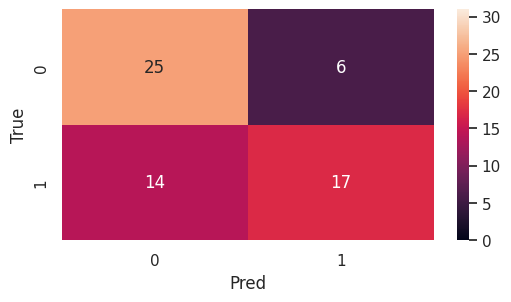

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSize': 5, 'filter': 'MinFilter', 'zeroThreshold': 0.33, 'sumThreshold': 50.9, 'lossFn': 'L1', 'gaussianFilterSigma': 3}
mean pos: 90.19005888508212, std pos: 116.53162185051957
mean neg: 44.97617345279263, std neg: 91.18523099686581
lowest pos: 1.0851986408233643, highest pos: 562.4619140625
lowest neg: 0.0, highest neg: 486.3947448730469
accuracy: 0.6774193548387096
precision: 0.72
recall: 0.5806451612903226
f1: 0.6428571428571428


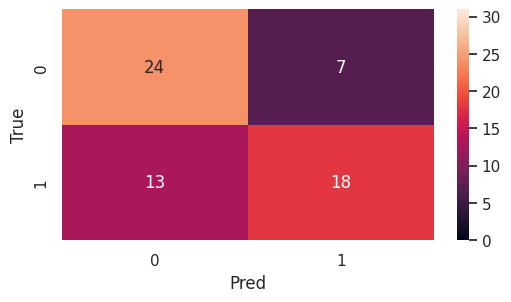

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSize': 5, 'filter': 'MinFilter', 'zeroThreshold': 0.33, 'sumThreshold': 50.9, 'lossFn': 'L1', 'gaussianFilterSigma': 5}
mean pos: 89.84929686207926, std pos: 117.1241867203918
mean neg: 44.701222415893305, std neg: 90.9991513021955
lowest pos: 1.075361967086792, highest pos: 567.4938354492188
lowest neg: 0.0, highest neg: 485.4342956542969
accuracy: 0.6774193548387096
precision: 0.72
recall: 0.5806451612903226
f1: 0.6428571428571428


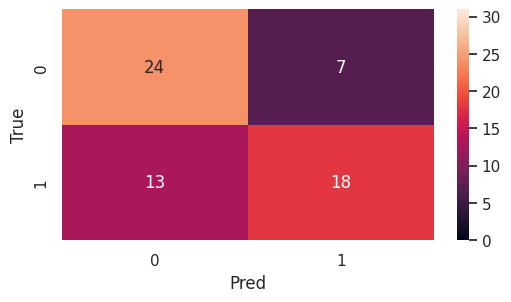

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSize': 5, 'filter': 'MinFilter', 'zeroThreshold': 0.33, 'sumThreshold': 50.9, 'lossFn': 'L1', 'gaussianFilterSigma': 7}
mean pos: 89.73489595997718, std pos: 117.19019590767087
mean neg: 44.34649059464854, std neg: 90.30766624231795
lowest pos: 1.0726349353790283, highest pos: 568.3015747070312
lowest neg: 0.0, highest neg: 481.718017578125
accuracy: 0.6774193548387096
precision: 0.72
recall: 0.5806451612903226
f1: 0.6428571428571428


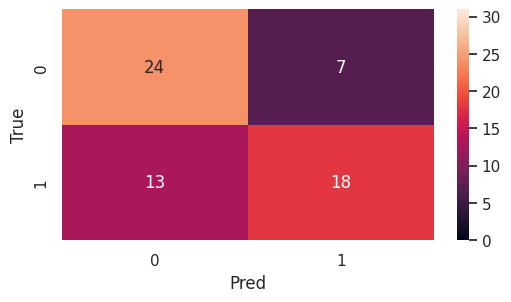

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSize': 5, 'filter': 'MinFilter', 'zeroThreshold': 0.33, 'sumThreshold': 50.9, 'lossFn': 'L1', 'gaussianFilterSigma': 9}
mean pos: 89.64635612887722, std pos: 117.27047340977958
mean neg: 44.34763719958644, std neg: 90.33406953380185
lowest pos: 1.0715126991271973, highest pos: 568.89111328125
lowest neg: 0.0, highest neg: 481.86328125
accuracy: 0.6774193548387096
precision: 0.72
recall: 0.5806451612903226
f1: 0.6428571428571428


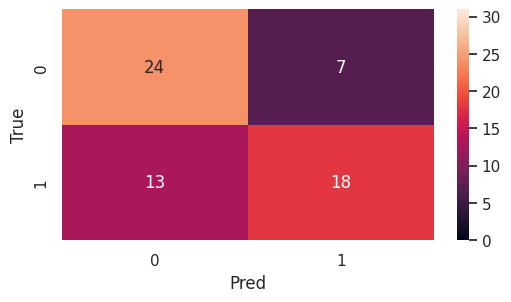

/tmp/ipykernel_503004/3860864987.py:105: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar([i-0.1 for i in range(len(posVals["mean"]))], posVals["mean"], yerr=posVals["std"],fmt='.k', capsize=5, label="pos (mean and std)", color="tomato")
/tmp/ipykernel_503004/3860864987.py:106: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar([i+0.1 for i in range(len(negVals["mean"]))], negVals["mean"], yerr=negVals["std"],fmt='.k', capsize=5, label="neg (mean and std)", color="cornflowerblue")


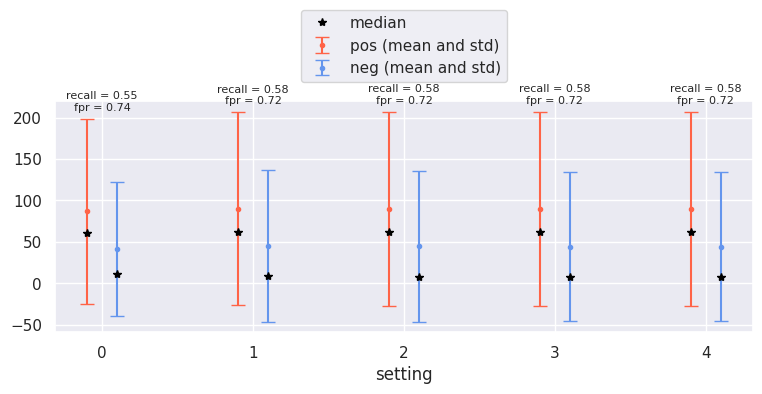

In [37]:
# distributions = dict(
#     cameras = [["NEN1", "SBU3"]], #, ["SBU4"]
#     balanced = [True, False],
#     distinctCAETraining = [True, False],
#     gaussianFilterSize = [5],
#     gaussianFilterSigma = [3, 5],
#     filter = ["MinFilter"], #["MinFilter", "GaussianFilter"]
#     zeroThreshold = np.random.uniform(low=0.15, high=0.4, size=30), # uniform dist on loc, loc+scale -> uniform(loc, scale) #threshold for zeroing out the image
#     sumThreshold = np.random.uniform(low=20, high=50, size=30),
#     lossFn = ["L1"]#["MSE", "L1"],
# )

# investigation of gaussian filter sigma
startState = dict(
    cameras = ["NEN1", "SBU3"], #, ["SBU4"]
    balanced = True,
    distinctCAETraining = False,
    gaussianFilterSize = 5,
    filter = "MinFilter", #["MinFilter", "GaussianFilter"]
    zeroThreshold = 0.175, # uniform dist on loc, loc+scale -> uniform(loc, scale) #threshold for zeroing out the image
    sumThreshold = 50.9,
    lossFn = "L1"
)

sigmaArr = [1, 3, 5, 7, 9]
settings = [dict(startState, gaussianFilterSigma=sigma) for sigma in sigmaArr]
evaluateAndPlotSettings(settings)

### evaluation of different Means for the Gaussian Filter

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSigma': 1, 'filter': 'MinFilter', 'zeroThreshold': 0.31, 'sumThreshold': 120, 'lossFn': 'L1', 'gaussianFilterSize': 3}
mean pos: 89.23617697531178, std pos: 110.65572900201154
mean neg: 42.0238933822801, std neg: 78.68936170123622
lowest pos: 1.4729993343353271, highest pos: 538.9820556640625
lowest neg: 0.0, highest neg: 411.7356872558594
accuracy: 0.5161290322580645
precision: 0.5555555555555556
recall: 0.16129032258064516
f1: 0.25


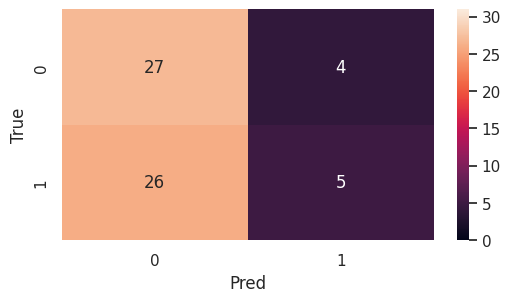

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSigma': 1, 'filter': 'MinFilter', 'zeroThreshold': 0.31, 'sumThreshold': 120, 'lossFn': 'L1', 'gaussianFilterSize': 5}
mean pos: 92.5161846914599, std pos: 113.32126549884195
mean neg: 46.069465687198026, std neg: 88.85802295633187
lowest pos: 2.401731252670288, highest pos: 548.966796875
lowest neg: 0.0, highest neg: 468.97540283203125
accuracy: 0.5161290322580645
precision: 0.5555555555555556
recall: 0.16129032258064516
f1: 0.25


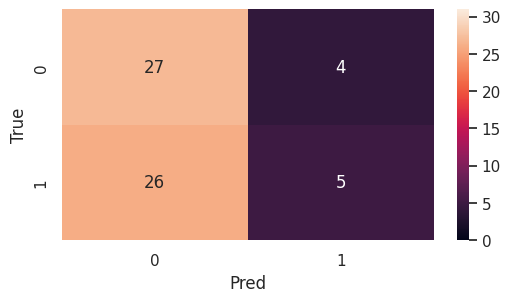

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSigma': 1, 'filter': 'MinFilter', 'zeroThreshold': 0.31, 'sumThreshold': 120, 'lossFn': 'L1', 'gaussianFilterSize': 7}
mean pos: 92.5249579183517, std pos: 113.29924038227891
mean neg: 45.96846571853084, std neg: 89.01087966951474
lowest pos: 2.3867268562316895, highest pos: 549.4750366210938
lowest neg: 0.0, highest neg: 469.6361083984375
accuracy: 0.5161290322580645
precision: 0.5555555555555556
recall: 0.16129032258064516
f1: 0.25


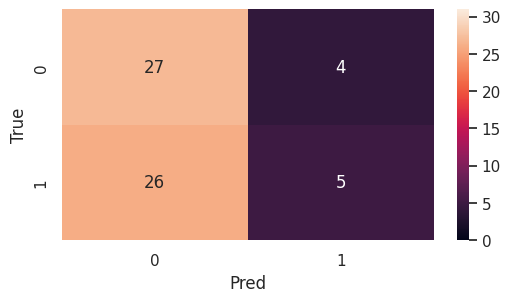

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSigma': 1, 'filter': 'MinFilter', 'zeroThreshold': 0.31, 'sumThreshold': 120, 'lossFn': 'L1', 'gaussianFilterSize': 9}
mean pos: 92.50684979654127, std pos: 113.28285062803401
mean neg: 45.923278410588544, std neg: 88.90054216007483
lowest pos: 2.38607120513916, highest pos: 549.42724609375
lowest neg: 0.0, highest neg: 468.98577880859375
accuracy: 0.5161290322580645
precision: 0.5555555555555556
recall: 0.16129032258064516
f1: 0.25


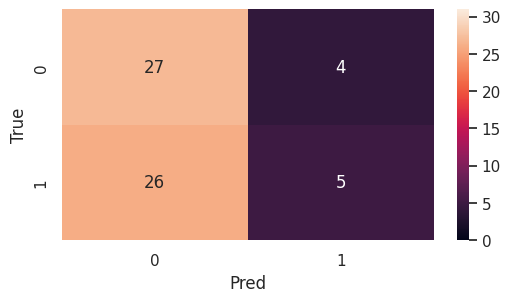

/tmp/ipykernel_503004/3860864987.py:105: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar([i-0.1 for i in range(len(posVals["mean"]))], posVals["mean"], yerr=posVals["std"],fmt='.k', capsize=5, label="pos (mean and std)", color="tomato")
/tmp/ipykernel_503004/3860864987.py:106: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar([i+0.1 for i in range(len(negVals["mean"]))], negVals["mean"], yerr=negVals["std"],fmt='.k', capsize=5, label="neg (mean and std)", color="cornflowerblue")


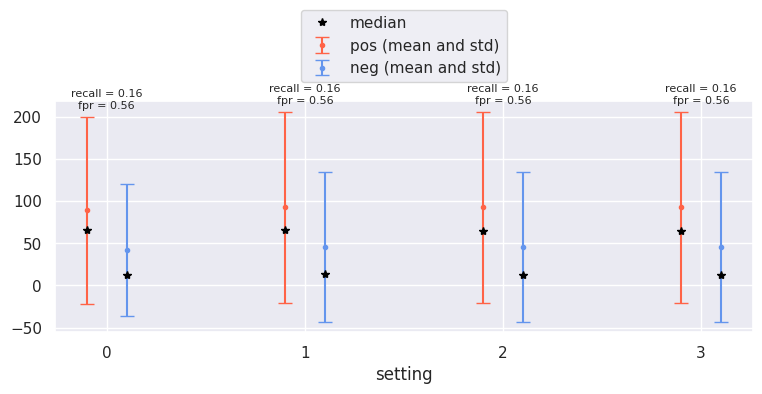

In [36]:
# distributions = dict(
#     cameras = [["NEN1", "SBU3"]], #, ["SBU4"]
#     balanced = [True, False],
#     distinctCAETraining = [True, False],
#     gaussianFilterSize = [5],
#     gaussianFilterSigma = [3, 5],
#     filter = ["MinFilter"], #["MinFilter", "GaussianFilter"]
#     zeroThreshold = np.random.uniform(low=0.15, high=0.4, size=30), # uniform dist on loc, loc+scale -> uniform(loc, scale) #threshold for zeroing out the image
#     sumThreshold = np.random.uniform(low=20, high=50, size=30),
#     lossFn = ["L1"]#["MSE", "L1"],
# )

# investigation of gaussian filter sigma
startState = dict(
    cameras = ["NEN1", "SBU3"], #, ["SBU4"]
    balanced = True,
    distinctCAETraining = False,
    gaussianFilterSigma = 1,
    filter = "MinFilter", #["MinFilter", "GaussianFilter"]
    zeroThreshold = 0.31, # uniform dist on loc, loc+scale -> uniform(loc, scale) #threshold for zeroing out the image
    sumThreshold = 120,
    lossFn = "L1"
)

sizeArr = [3, 5, 7, 9]
settings = [dict(startState, gaussianFilterSize=size) for size in sizeArr]
evaluateAndPlotSettings(settings)

### evaluation of different zeroThresholds

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'filter': 'MinFilter', 'sumThreshold': 60, 'lossFn': 'L1', 'zeroThreshold': 0.0}
mean pos: 654.1441483036165, std pos: 279.03600074473025
mean neg: 583.6721388293851, std neg: 416.37684144780945
lowest pos: 217.71099853515625, highest pos: 1626.04052734375
lowest neg: 174.86001586914062, highest neg: 2171.205810546875
accuracy: 0.5
precision: 0.5
recall: 1.0
f1: 0.6666666666666666


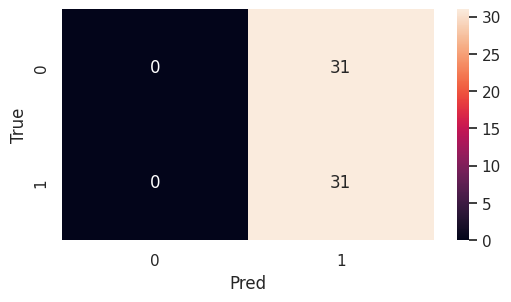

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'filter': 'MinFilter', 'sumThreshold': 60, 'lossFn': 'L1', 'zeroThreshold': 0.025}
mean pos: 512.9383923930507, std pos: 263.36736817219986
mean neg: 464.12313325943484, std neg: 412.180354574509
lowest pos: 128.03038024902344, highest pos: 1442.83349609375
lowest neg: 100.68358612060547, highest neg: 2047.263427734375
accuracy: 0.5
precision: 0.5
recall: 1.0
f1: 0.6666666666666666


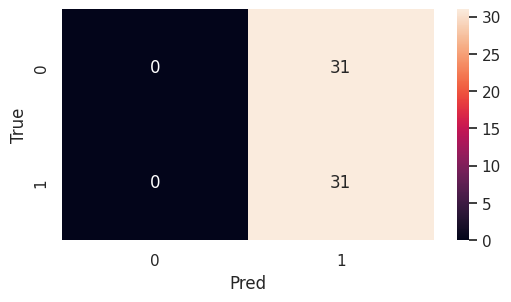

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'filter': 'MinFilter', 'sumThreshold': 60, 'lossFn': 'L1', 'zeroThreshold': 0.05}
mean pos: 394.8067651564075, std pos: 228.8121490919285
mean neg: 363.68776186050906, std neg: 376.0714169041785
lowest pos: 85.64323425292969, highest pos: 1220.64404296875
lowest neg: 66.23428344726562, highest neg: 1852.939208984375
accuracy: 0.5
precision: 0.5
recall: 1.0
f1: 0.6666666666666666


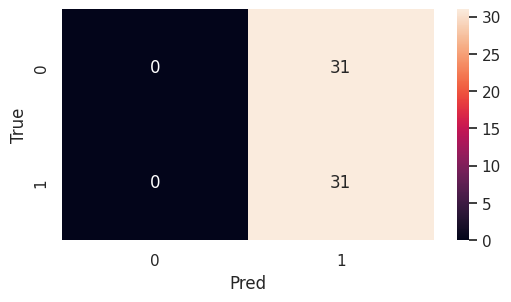

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'filter': 'MinFilter', 'sumThreshold': 60, 'lossFn': 'L1', 'zeroThreshold': 0.07500000000000001}
mean pos: 314.71019966371597, std pos: 199.75489926957317
mean neg: 287.1795816729146, std neg: 332.3944115435666
lowest pos: 61.342185974121094, highest pos: 1056.997802734375
lowest neg: 37.23863983154297, highest neg: 1634.9183349609375
accuracy: 0.5806451612903226
precision: 0.543859649122807
recall: 1.0
f1: 0.7045454545454546


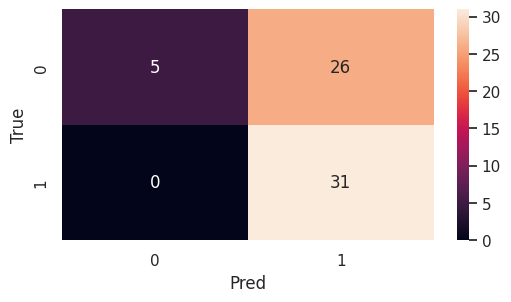

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'filter': 'MinFilter', 'sumThreshold': 60, 'lossFn': 'L1', 'zeroThreshold': 0.1}
mean pos: 258.48716834283647, std pos: 178.82901880418686
mean neg: 229.8040731491581, std neg: 292.988766480992
lowest pos: 47.59779357910156, highest pos: 935.3101806640625
lowest neg: 20.16667938232422, highest neg: 1451.78662109375
accuracy: 0.5967741935483871
precision: 0.5555555555555556
recall: 0.967741935483871
f1: 0.7058823529411765


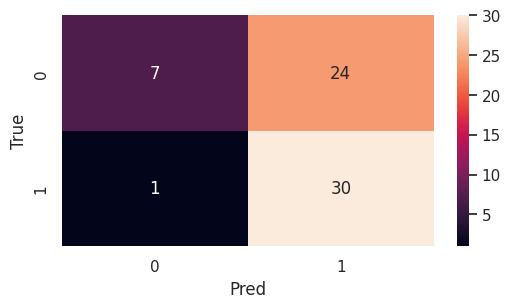

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'filter': 'MinFilter', 'sumThreshold': 60, 'lossFn': 'L1', 'zeroThreshold': 0.125}
mean pos: 217.91788310389364, std pos: 163.2390901950364
mean neg: 185.60434199917702, std neg: 255.15074970517185
lowest pos: 35.78887939453125, highest pos: 844.913330078125
lowest neg: 10.776912689208984, highest neg: 1278.52685546875
accuracy: 0.6451612903225806
precision: 0.5882352941176471
recall: 0.967741935483871
f1: 0.7317073170731707


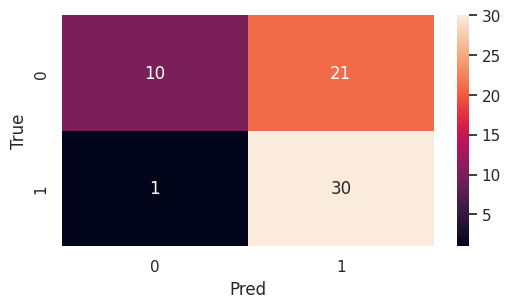

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'filter': 'MinFilter', 'sumThreshold': 60, 'lossFn': 'L1', 'zeroThreshold': 0.15000000000000002}
mean pos: 188.46788818605484, std pos: 153.2457464182148
mean neg: 151.5972735035804, std neg: 223.5280146699196
lowest pos: 27.685182571411133, highest pos: 785.441162109375
lowest neg: 3.8129515647888184, highest neg: 1130.275634765625
accuracy: 0.6451612903225806
precision: 0.6046511627906976
recall: 0.8387096774193549
f1: 0.7027027027027026


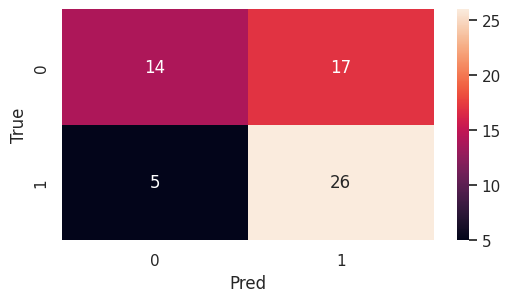

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'filter': 'MinFilter', 'sumThreshold': 60, 'lossFn': 'L1', 'zeroThreshold': 0.17500000000000002}
mean pos: 165.90064485611455, std pos: 144.3134320433503
mean neg: 125.54540477260467, std neg: 197.36168722030837
lowest pos: 20.679237365722656, highest pos: 731.921875
lowest neg: 1.9213790893554688, highest neg: 1011.23974609375
accuracy: 0.6774193548387096
precision: 0.6410256410256411
recall: 0.8064516129032258
f1: 0.7142857142857142


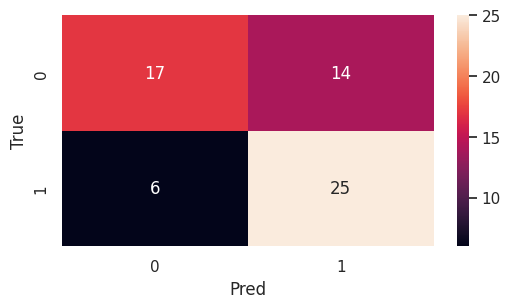

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'filter': 'MinFilter', 'sumThreshold': 60, 'lossFn': 'L1', 'zeroThreshold': 0.2}
mean pos: 146.74210166931152, std pos: 137.0740657358092
mean neg: 104.87358098260817, std neg: 173.4365879037486
lowest pos: 17.534564971923828, highest pos: 686.9458618164062
lowest neg: 0.8929457664489746, highest neg: 895.8701171875
accuracy: 0.6612903225806451
precision: 0.6388888888888888
recall: 0.7419354838709677
f1: 0.6865671641791045


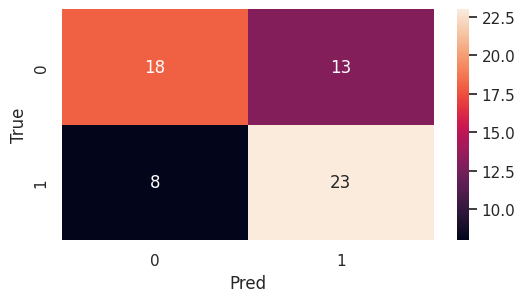

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'filter': 'MinFilter', 'sumThreshold': 60, 'lossFn': 'L1', 'zeroThreshold': 0.225}
mean pos: 131.39923049557595, std pos: 131.8961815942678
mean neg: 87.5414791655156, std neg: 151.96493370752853
lowest pos: 11.20262622833252, highest pos: 653.7340087890625
lowest neg: 0.2899364233016968, highest neg: 789.9520263671875
accuracy: 0.6129032258064516
precision: 0.6129032258064516
recall: 0.6129032258064516
f1: 0.6129032258064516


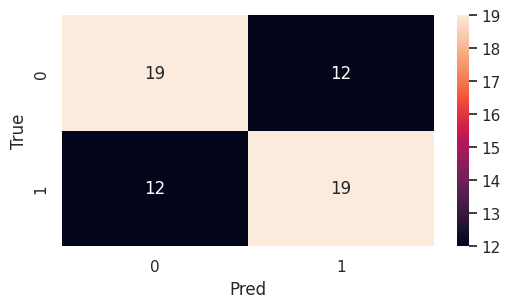

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'filter': 'MinFilter', 'sumThreshold': 60, 'lossFn': 'L1', 'zeroThreshold': 0.25}
mean pos: 118.92030755935177, std pos: 126.80929388301506
mean neg: 74.32948968198991, std neg: 134.5034187838769
lowest pos: 6.955841064453125, highest pos: 622.5211791992188
lowest neg: 0.0, highest neg: 703.73779296875
accuracy: 0.6290322580645161
precision: 0.6333333333333333
recall: 0.6129032258064516
f1: 0.6229508196721313


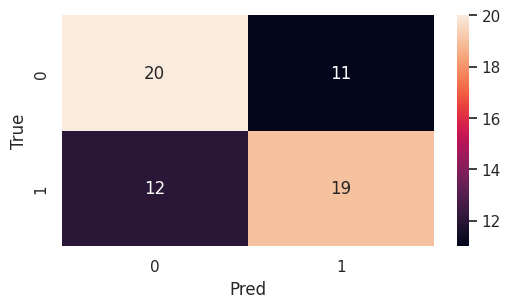

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'filter': 'MinFilter', 'sumThreshold': 60, 'lossFn': 'L1', 'zeroThreshold': 0.275}
mean pos: 108.02088212966919, std pos: 123.28875181437628
mean neg: 63.71968461428919, std neg: 120.22829748886346
lowest pos: 4.083064556121826, highest pos: 601.6979370117188
lowest neg: 0.0, highest neg: 632.023193359375
accuracy: 0.6774193548387096
precision: 0.7037037037037037
recall: 0.6129032258064516
f1: 0.6551724137931035


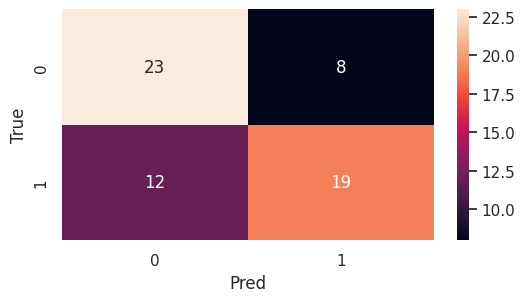

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'filter': 'MinFilter', 'sumThreshold': 60, 'lossFn': 'L1', 'zeroThreshold': 0.30000000000000004}
mean pos: 99.29172037109252, std pos: 119.98210367171717
mean neg: 53.84498450448436, std neg: 105.16104759600897
lowest pos: 1.706842064857483, highest pos: 584.7605590820312
lowest neg: 0.0, highest neg: 557.0096435546875
accuracy: 0.6774193548387096
precision: 0.72
recall: 0.5806451612903226
f1: 0.6428571428571428


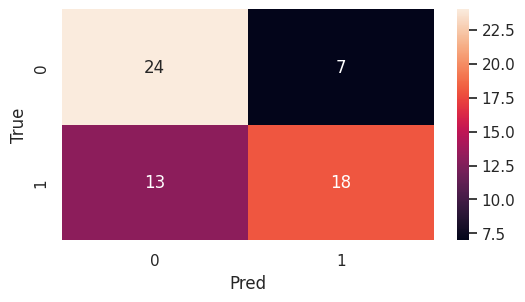

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'filter': 'MinFilter', 'sumThreshold': 60, 'lossFn': 'L1', 'zeroThreshold': 0.325}
mean pos: 91.59163428121998, std pos: 117.58181842703976
mean neg: 46.021109504084436, std neg: 92.49240851207058
lowest pos: 1.392770767211914, highest pos: 569.7811279296875
lowest neg: 0.0, highest neg: 491.98931884765625
accuracy: 0.6774193548387096
precision: 0.7619047619047619
recall: 0.5161290322580645
f1: 0.6153846153846153


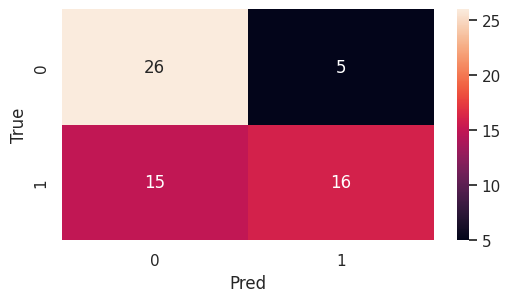

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'filter': 'MinFilter', 'sumThreshold': 60, 'lossFn': 'L1', 'zeroThreshold': 0.35000000000000003}
mean pos: 84.19762304905922, std pos: 115.18455917961413
mean neg: 39.10504220954834, std neg: 81.83202041914508
lowest pos: 0.39162319898605347, highest pos: 557.705078125
lowest neg: 0.0, highest neg: 438.238525390625
accuracy: 0.6290322580645161
precision: 0.7222222222222222
recall: 0.41935483870967744
f1: 0.5306122448979592


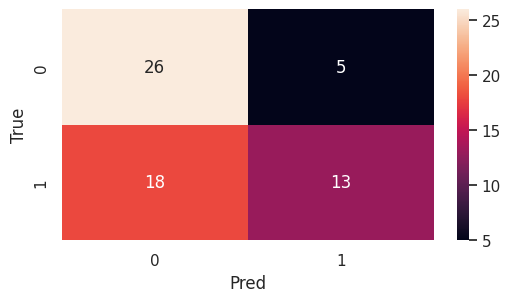

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'filter': 'MinFilter', 'sumThreshold': 60, 'lossFn': 'L1', 'zeroThreshold': 0.375}
mean pos: 78.01718286352772, std pos: 113.356208963625
mean neg: 33.03049355168496, std neg: 70.94523949800227
lowest pos: 0.0, highest pos: 548.7262573242188
lowest neg: 0.0, highest neg: 382.28173828125
accuracy: 0.6451612903225806
precision: 0.7647058823529411
recall: 0.41935483870967744
f1: 0.5416666666666666


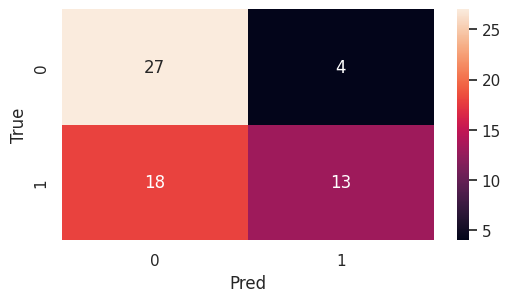

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'filter': 'MinFilter', 'sumThreshold': 60, 'lossFn': 'L1', 'zeroThreshold': 0.4}
mean pos: 72.64001294682103, std pos: 110.81713594363963
mean neg: 28.03455546690572, std neg: 61.27803711358119
lowest pos: 0.0, highest pos: 538.2967529296875
lowest neg: 0.0, highest neg: 331.92034912109375
accuracy: 0.6290322580645161
precision: 0.75
recall: 0.3870967741935484
f1: 0.5106382978723403


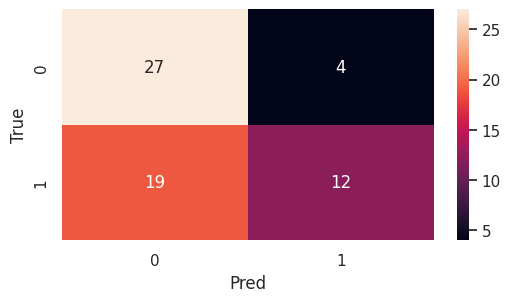

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'filter': 'MinFilter', 'sumThreshold': 60, 'lossFn': 'L1', 'zeroThreshold': 0.42500000000000004}
mean pos: 67.23199176980603, std pos: 108.95261940283068
mean neg: 23.51855697266517, std neg: 51.04920180818117
lowest pos: 0.0, highest pos: 530.455810546875
lowest neg: 0.0, highest neg: 275.1309814453125
accuracy: 0.6129032258064516
precision: 0.7333333333333333
recall: 0.3548387096774194
f1: 0.47826086956521735


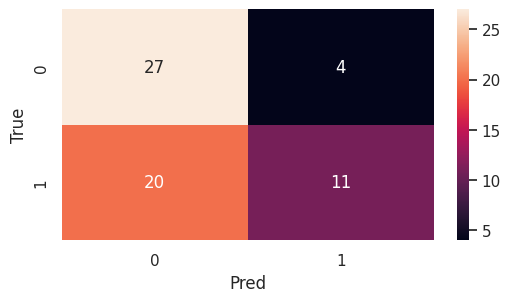

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'filter': 'MinFilter', 'sumThreshold': 60, 'lossFn': 'L1', 'zeroThreshold': 0.45}
mean pos: 63.17166145386234, std pos: 107.53175398304421
mean neg: 19.12939344298455, std neg: 43.049869098036275
lowest pos: 0.0, highest pos: 524.3631591796875
lowest neg: 0.0, highest neg: 232.76788330078125
accuracy: 0.6451612903225806
precision: 0.8461538461538461
recall: 0.3548387096774194
f1: 0.5


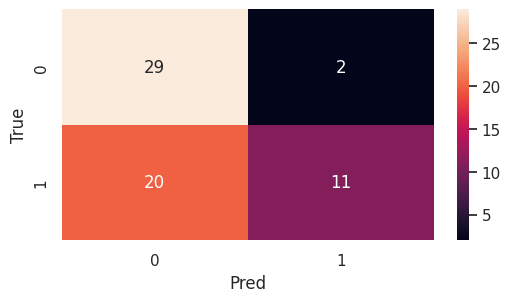

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'filter': 'MinFilter', 'sumThreshold': 60, 'lossFn': 'L1', 'zeroThreshold': 0.47500000000000003}
mean pos: 58.89567435941389, std pos: 105.60933955778673
mean neg: 15.709721057645735, std neg: 36.78956816435208
lowest pos: 0.0, highest pos: 518.321533203125
lowest neg: 0.0, highest neg: 200.40188598632812
accuracy: 0.6290322580645161
precision: 0.8333333333333334
recall: 0.3225806451612903
f1: 0.4651162790697674


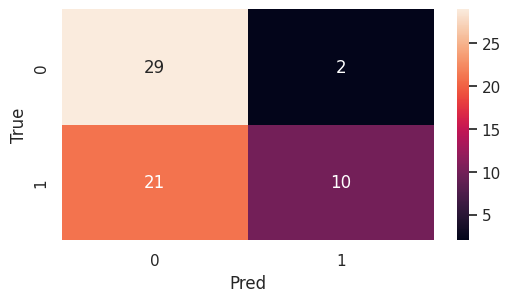

/tmp/ipykernel_503004/4285669797.py:104: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar([i-0.1 for i in range(len(posVals["mean"]))], posVals["mean"], yerr=posVals["std"],fmt='.k', capsize=5, label="pos (mean and std)", color="cornflowerblue")
/tmp/ipykernel_503004/4285669797.py:105: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar([i+0.1 for i in range(len(negVals["mean"]))], negVals["mean"], yerr=negVals["std"],fmt='.k', capsize=5, label="neg (mean and std)", color="tomato")


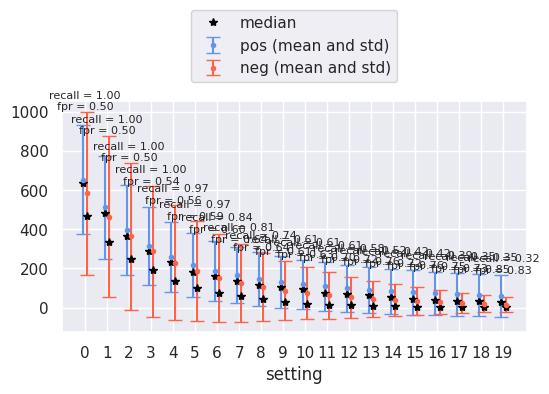

In [27]:
# distributions = dict(
#     cameras = [["NEN1", "SBU3"]], #, ["SBU4"]
#     balanced = [True, False],
#     distinctCAETraining = [True, False],
#     gaussianFilterSize = [5],
#     gaussianFilterSigma = [3, 5],
#     filter = ["MinFilter"], #["MinFilter", "GaussianFilter"]
#     zeroThreshold = np.random.uniform(low=0.15, high=0.4, size=30), # uniform dist on loc, loc+scale -> uniform(loc, scale) #threshold for zeroing out the image
#     sumThreshold = np.random.uniform(low=20, high=50, size=30),
#     lossFn = ["L1"]#["MSE", "L1"],
# )

# investigation of gaussian filter sigma
startState = dict(
    cameras = ["NEN1", "SBU3"],
    balanced = True,
    distinctCAETraining = False,
    gaussianFilterSigma = 5,
    gaussianFilterSize = 5,
    filter = "MinFilter", 
    sumThreshold = 60,
    lossFn = "L1"
)
zeroThresholdArr = np.arange(0, 0.5, 0.025)
settings = [dict(startState, zeroThreshold=zeroThreshold) for zeroThreshold in zeroThresholdArr]
evaluateAndPlotSettings(settings)

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'zeroThreshold': 0.3, 'filter': 'MinFilter', 'lossFn': 'L1', 'sumThreshold': 20}
mean pos: 99.29172006345564, std pos: 119.98210379641166
mean neg: 53.84498514090815, std neg: 105.16104807334015
lowest pos: 1.706842064857483, highest pos: 584.7605590820312
lowest neg: 0.0, highest neg: 557.0096435546875
accuracy: 0.6774193548387096
precision: 0.6410256410256411
recall: 0.8064516129032258
f1: 0.7142857142857142


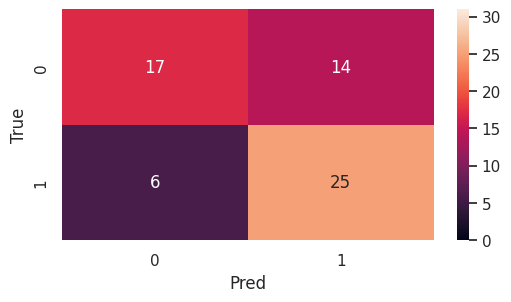

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'zeroThreshold': 0.3, 'filter': 'MinFilter', 'lossFn': 'L1', 'sumThreshold': 30}
mean pos: 99.29172186313137, std pos: 119.98211171737199
mean neg: 53.84498514763771, std neg: 105.16104805569746
lowest pos: 1.706842064857483, highest pos: 584.7606201171875
lowest neg: 0.0, highest neg: 557.0096435546875
accuracy: 0.6612903225806451
precision: 0.6388888888888888
recall: 0.7419354838709677
f1: 0.6865671641791045


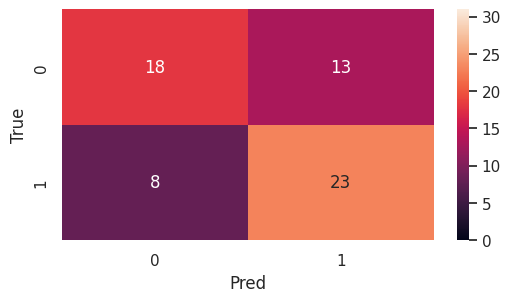

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'zeroThreshold': 0.3, 'filter': 'MinFilter', 'lossFn': 'L1', 'sumThreshold': 40}
mean pos: 99.29171943280005, std pos: 119.98210322694437
mean neg: 53.84498521877873, std neg: 105.16104807793992
lowest pos: 1.706842064857483, highest pos: 584.7605590820312
lowest neg: 0.0, highest neg: 557.0096435546875
accuracy: 0.6451612903225806
precision: 0.6451612903225806
recall: 0.6451612903225806
f1: 0.6451612903225806


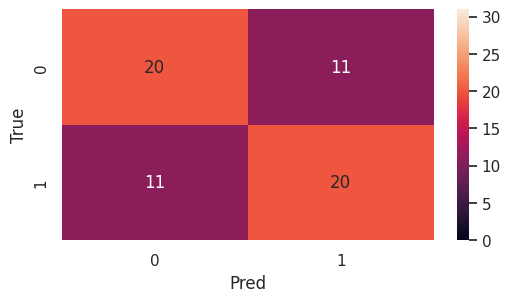

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'zeroThreshold': 0.3, 'filter': 'MinFilter', 'lossFn': 'L1', 'sumThreshold': 50}
mean pos: 99.29172087484791, std pos: 119.98210592650392
mean neg: 53.84498461984819, std neg: 105.16104755696782
lowest pos: 1.7068419456481934, highest pos: 584.7605590820312
lowest neg: 0.0, highest neg: 557.0096435546875
accuracy: 0.6774193548387096
precision: 0.7037037037037037
recall: 0.6129032258064516
f1: 0.6551724137931035


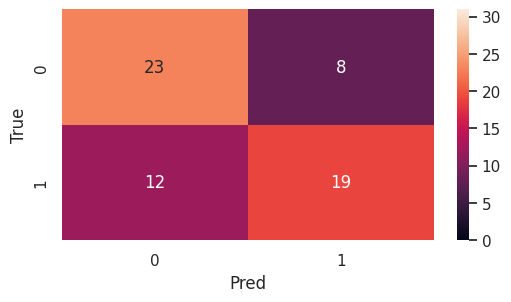

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'zeroThreshold': 0.3, 'filter': 'MinFilter', 'lossFn': 'L1', 'sumThreshold': 60}
mean pos: 99.29172154011265, std pos: 119.98211118543453
mean neg: 53.844983181645794, std neg: 105.16103864780675
lowest pos: 1.706842064857483, highest pos: 584.7606201171875
lowest neg: 0.0, highest neg: 557.0095825195312
accuracy: 0.6774193548387096
precision: 0.72
recall: 0.5806451612903226
f1: 0.6428571428571428


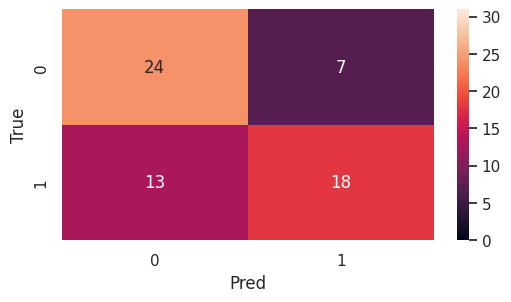

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'zeroThreshold': 0.3, 'filter': 'MinFilter', 'lossFn': 'L1', 'sumThreshold': 70}
mean pos: 99.29172009421933, std pos: 119.98210371469128
mean neg: 53.844985117835385, std neg: 105.16104808158876
lowest pos: 1.706842064857483, highest pos: 584.7605590820312
lowest neg: 0.0, highest neg: 557.0096435546875
accuracy: 0.6451612903225806
precision: 0.7142857142857143
recall: 0.4838709677419355
f1: 0.5769230769230769


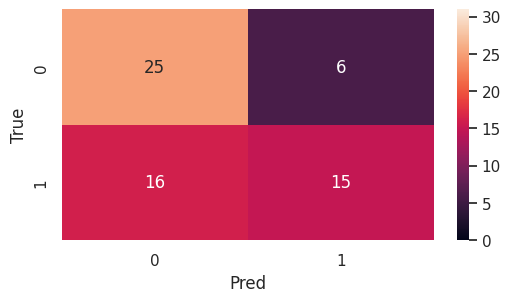

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'zeroThreshold': 0.3, 'filter': 'MinFilter', 'lossFn': 'L1', 'sumThreshold': 80}
mean pos: 99.29172227844116, std pos: 119.98211155624078
mean neg: 53.8449850649603, std neg: 105.16104810344068
lowest pos: 1.706842064857483, highest pos: 584.7606201171875
lowest neg: 0.0, highest neg: 557.0096435546875
accuracy: 0.6612903225806451
precision: 0.75
recall: 0.4838709677419355
f1: 0.5882352941176471


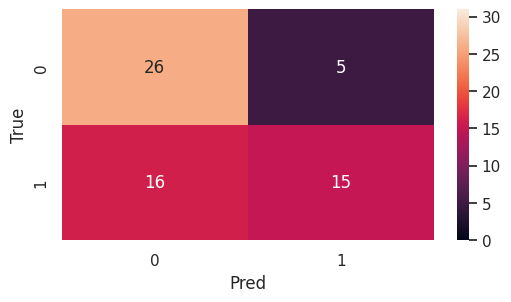

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'zeroThreshold': 0.3, 'filter': 'MinFilter', 'lossFn': 'L1', 'sumThreshold': 90}
mean pos: 99.29171964814586, std pos: 119.98210322199199
mean neg: 53.84498475059386, std neg: 105.16104754853946
lowest pos: 1.706842064857483, highest pos: 584.7605590820312
lowest neg: 0.0, highest neg: 557.0096435546875
accuracy: 0.5967741935483871
precision: 0.6875
recall: 0.3548387096774194
f1: 0.4680851063829787


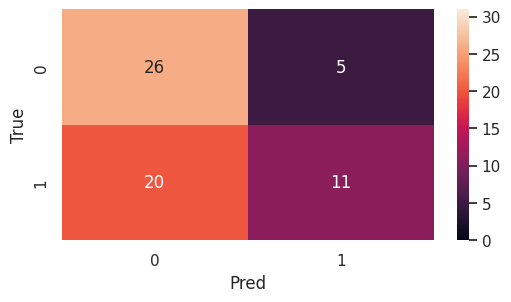

/tmp/ipykernel_503004/3860864987.py:105: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar([i-0.1 for i in range(len(posVals["mean"]))], posVals["mean"], yerr=posVals["std"],fmt='.k', capsize=5, label="pos (mean and std)", color="tomato")
/tmp/ipykernel_503004/3860864987.py:106: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar([i+0.1 for i in range(len(negVals["mean"]))], negVals["mean"], yerr=negVals["std"],fmt='.k', capsize=5, label="neg (mean and std)", color="cornflowerblue")


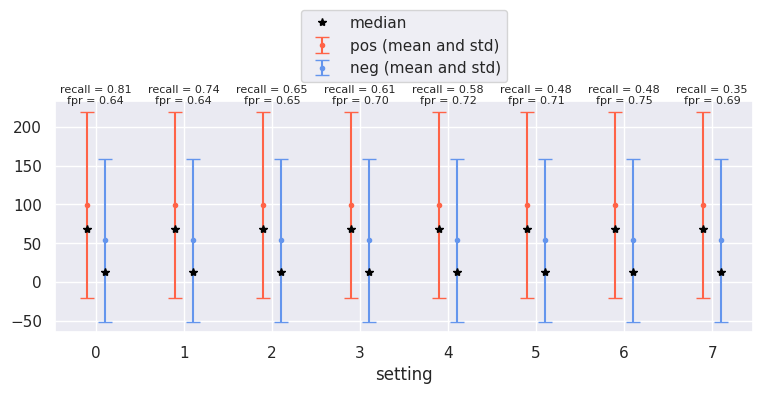

In [41]:
# distributions = dict(
#     cameras = [["NEN1", "SBU3"]], #, ["SBU4"]
#     balanced = [True, False],
#     distinctCAETraining = [True, False],
#     gaussianFilterSize = [5],
#     gaussianFilterSigma = [3, 5],
#     filter = ["MinFilter"], #["MinFilter", "GaussianFilter"]
#     zeroThreshold = np.random.uniform(low=0.15, high=0.4, size=30), # uniform dist on loc, loc+scale -> uniform(loc, scale) #threshold for zeroing out the image
#     sumThreshold = np.random.uniform(low=20, high=50, size=30),
#     lossFn = ["L1"]#["MSE", "L1"],
# )

# investigation of gaussian filter sigma
startState = dict(
    cameras = ["NEN1", "SBU3"],
    balanced = True,
    distinctCAETraining = False,
    gaussianFilterSigma = 5,
    gaussianFilterSize = 5,
    zeroThreshold = 0.3,
    filter = "MinFilter", 
    lossFn = "L1"
)
sumThresholdArr = np.arange(20, 100, 10)
settings = [dict(startState, sumThreshold=sumThreshold) for sumThreshold in sumThresholdArr]
evaluateAndPlotSettings(settings)

# Evaluation of model with train, val and test set

In [14]:
def classify(params: dict, caeModel, loaderParams, mode = "fit"):
    """
    mode: fit or predict - if fit, no sumThreshold needed
    """
    dataset = DatasetThreeConsecutive(resize_to=caeModel.imsize, **loaderParams)
    dataLoader = DataLoader(dataset, batch_size=8, shuffle=False, num_workers=2)

    blur = GaussianBlur(kernel_size=params["gaussianFilterSize"], sigma=params["gaussianFilterSigma"]) #TODO: make this a parameter
    lossFn = F.mse_loss if params["lossFn"] == "MSE" else F.l1_loss
    vals = []

    for (imArr, lblArr, camera, ImagePath) in dataLoader:
        isTrainingCamera = camera in caeLoaded.hparams.cameras
        prevImg = imArr[0] #alwasy #batch_size images
        currImg = imArr[1]
        nextImg = imArr[2]

        prevPred, currPred, nextPred = [unnorm(caeLoaded(x.to(caeLoaded.device))) for x in [prevImg, currImg, nextImg]]
        prevImg, currImg, nextImg = [unnorm(x) for x in [prevImg, currImg, nextImg]]


        prevImgBlurred, currImgBlurred, nextImgBlurred = [blur.forward(x).to(prevPred.device) for x in [prevImg, currImg, nextImg]]
    
        
        prevImd, currImd, nextImd = [torch.sum(lossFn(imgBlurred, pred, reduction='none'), dim=1) for imgBlurred, pred in zip([prevImgBlurred, currImgBlurred, nextImgBlurred], [prevPred, currPred, nextPred])]

        prevToCurrImd = torch.clamp(torch.sub(currImd, prevImd), min= 0)
        nextToCurrImd = torch.clamp(torch.sub(currImd, nextImd), min= 0)

        prevNextCurrImd = torch.div(torch.add(prevToCurrImd, nextToCurrImd), 2)

        prevNextCurrImdMin = torch.stack([min_filter(x, kernel_size=3) for x in prevNextCurrImd]) #TODO: evtl make this as before
        

        
        prevNextCurrImdMinThresh = torch.where(prevNextCurrImdMin < params["zeroThreshold"], torch.zeros_like(prevNextCurrImdMin), prevNextCurrImdMin)
        

        sumPrevNextCurrImdMin = torch.sum(prevNextCurrImdMinThresh, dim=(1, 2))

        if mode == "fit":

            for i in range(len(sumPrevNextCurrImdMin)):
                vals.append([lblArr[i].item(), sumPrevNextCurrImdMin[i].item()])
        else:
            predictions = (sumPrevNextCurrImdMin> params["sumThreshold"]).to(torch.int)

            for i in range(len(predictions)):
                vals.append([lblArr[i].item(), predictions[i].item(), sumPrevNextCurrImdMin[i].item()])
    
    vals = np.array(vals)
    return vals

In [15]:
def plotEvalMetrics(vals: np.array):
    confMat = confusion_matrix(vals[:, 0], vals[:,1])
    fig= plt.figure(figsize = (6,3))
    ax = fig.add_subplot(111)
    sns.heatmap(confMat, annot=True)
    plt.gca().collections[0].set_clim(0, len(vals)/2)
    ax.set_xlabel('Pred', fontsize=12)
    ax.set_ylabel('True', fontsize=12)
    onlyPos = vals[vals[:, 0] == 1]
    onlyNeg = vals[vals[:, 0] == 0]
    print(f'mean pos: {np.mean(onlyPos[:, 2])}, std pos: {np.std(onlyPos[:, 2])}')
    print(f'mean neg: {np.mean(onlyNeg[:, 2])}, std neg: {np.std(onlyNeg[:, 2])}')
    print(f'median pos: {np.median(onlyPos[:, 2])}, median neg: {np.median(onlyNeg[:, 2])}')
    print(f'lowest pos: {np.min(onlyPos[:, 2])}, highest pos: {np.max(onlyPos[:, 2])}')
    print(f'lowest neg: {np.min(onlyNeg[:, 2])}, highest neg: {np.max(onlyNeg[:, 2])}')


    print(f'accuracy: {accuracy_score(vals[:, 0], vals[:,1])}')
    print(f'precision: {precision_score(vals[:, 0], vals[:,1])}')
    print(f'recall: {recall_score(vals[:, 0], vals[:,1])}')
    print(f'f1: {f1_score(vals[:, 0], vals[:,1])}')
    plt.show()

In [16]:
def min_filter(tensor : torch.Tensor, kernel_size=3):
    # Unfold the tensor into sliding local blocks
    unfolded = tensor.unfold(0, kernel_size, 1)
    unfolded = unfolded.unfold(1, kernel_size, 1)
    # Compute the minimum in each of these blocks
    return unfolded.min(dim=-1)[0].min(dim=-1)[0]

CAE Params:
"batch_size":         16
"bottleneck":         128
"cameras":            ['NEN1', 'SBU3']
"gammaScheduler":     0.7879353477950641
"ldim":               16
"learning_rate":      0.003533238255084643
"num_workers_loader": 4
"transforms":         None
"weight_decay":       4.5387898639621974e-07
{'zeroThreshold': 0.12551326341093338, 'lossFn': 'L1', 'gaussianFilterSize': 5, 'gaussianFilterSigma': 3, 'filter': 'MinFilter'}
Training
mean pos: 139.85173383292178, std pos: 256.62292703218895, median pos: 68.83189392089844
mean neg: 91.71545020248983, std neg: 139.20995293868404, median neg: 23.829010009765625
Validation
mean pos: 105.71980008712181, std pos: 104.97161704270799
mean neg: 94.47011892994244, std neg: 261.5053406271623
median pos: 74.09220886230469, median neg: 13.424039840698242
lowest pos: 0.0, highest pos: 471.4224853515625
lowest neg: 0.0, highest neg: 1272.1666259765625
accuracy: 0.72
precision: 0.7727272727272727
recall: 0.6538461538461539
f1: 0.708333333333333

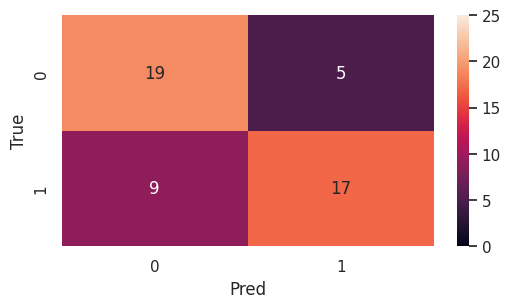

{'zeroThreshold': 0.19402725344777288, 'lossFn': 'L1', 'gaussianFilterSize': 5, 'gaussianFilterSigma': 3, 'filter': 'MinFilter'}
Training
mean pos: 91.570471001343, std pos: 189.32841965366617, median pos: 41.015724182128906
mean neg: 44.007423701030866, std neg: 76.94642894491348, median neg: 8.33032512664795
Validation
mean pos: 62.22871380012769, std pos: 76.13551878109939
mean neg: 59.05081695318222, std neg: 189.1267560395594
median pos: 40.049537658691406, median neg: 1.7051399946212769
lowest pos: 0.0, highest pos: 331.0640869140625
lowest neg: 0.0, highest neg: 928.029541015625
accuracy: 0.7
precision: 0.7894736842105263
recall: 0.5769230769230769
f1: 0.6666666666666666


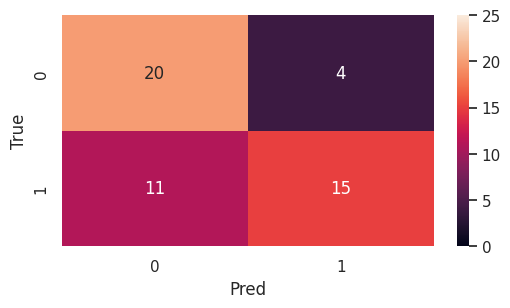

{'zeroThreshold': 0.2616450202010071, 'lossFn': 'L1', 'gaussianFilterSize': 5, 'gaussianFilterSigma': 3, 'filter': 'MinFilter'}
Training
mean pos: 64.10623485395607, std pos: 146.80878584735802, median pos: 17.10175323486328
mean neg: 22.86531241605808, std neg: 47.99512094922485, median neg: 1.7358765602111816
Validation
mean pos: 41.87597226179563, std pos: 62.3983349527606
mean neg: 40.05476253976425, std neg: 136.21613748658868
median pos: 16.54384422302246, median neg: 0.0
lowest pos: 0.0, highest pos: 258.3952941894531
lowest neg: 0.0, highest neg: 670.4334106445312
accuracy: 0.7
precision: 0.7619047619047619
recall: 0.6153846153846154
f1: 0.6808510638297872


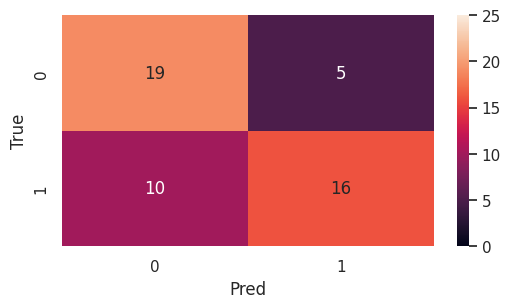

{'zeroThreshold': 0.30556585011902787, 'lossFn': 'L1', 'gaussianFilterSize': 5, 'gaussianFilterSigma': 5, 'filter': 'MinFilter'}
Training
mean pos: 52.03770019051055, std pos: 126.50293188214422, median pos: 10.444963455200195
mean neg: 15.506439750457739, std neg: 35.93594269785344, median neg: 0.3247281312942505
Validation
mean pos: 33.80176501549207, std pos: 55.491664520275705
mean neg: 31.465285285065573, std neg: 110.43110603370963
median pos: 8.405938148498535, median neg: 0.0
lowest pos: 0.0, highest pos: 216.4081268310547
lowest neg: 0.0, highest neg: 545.1970825195312
accuracy: 0.72
precision: 0.8
recall: 0.6153846153846154
f1: 0.6956521739130435


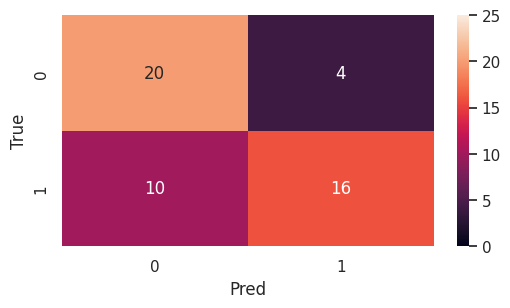

{'zeroThreshold': 0.12770157843063934, 'lossFn': 'L1', 'gaussianFilterSize': 5, 'gaussianFilterSigma': 1, 'filter': 'MinFilter'}
Training
mean pos: 128.30573024905064, std pos: 240.35375967350544, median pos: 63.819278717041016
mean neg: 75.27241126206015, std neg: 114.29574961579655, median neg: 19.59153938293457
Validation
mean pos: 93.16475449158595, std pos: 94.6281958059762
mean neg: 81.68710844467084, std neg: 225.9176265646757
median pos: 68.34919929504395, median neg: 12.147187232971191
lowest pos: 0.0, highest pos: 427.5308837890625
lowest neg: 0.0, highest neg: 1089.6451416015625
accuracy: 0.72
precision: 0.8
recall: 0.6153846153846154
f1: 0.6956521739130435


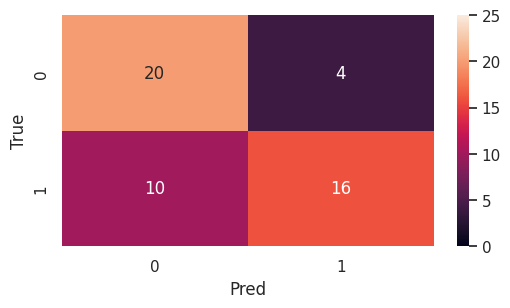

{'zeroThreshold': 0.3629167456888115, 'lossFn': 'L1', 'gaussianFilterSize': 5, 'gaussianFilterSigma': 1, 'filter': 'MinFilter'}
Training
mean pos: 41.17427877305259, std pos: 105.7451738186915, median pos: 6.545575141906738
mean neg: 9.659651209394653, std neg: 23.568589174250643, median neg: 0.0
Validation
mean pos: 26.053933647962715, std pos: 48.072280167711355
mean neg: 21.238492290178936, std neg: 73.10557378626345
median pos: 4.643283843994141, median neg: 0.0
lowest pos: 0.0, highest pos: 191.97122192382812
lowest neg: 0.0, highest neg: 360.350341796875
accuracy: 0.68
precision: 0.75
recall: 0.5769230769230769
f1: 0.6521739130434783


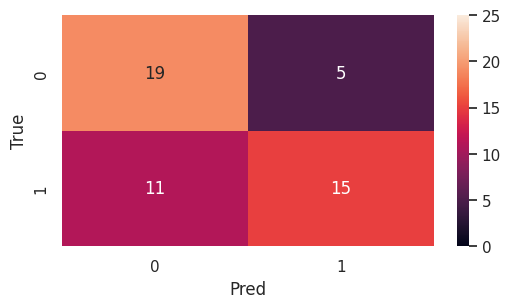

{'zeroThreshold': 0.2616450202010071, 'lossFn': 'L1', 'gaussianFilterSize': 3, 'gaussianFilterSigma': 3, 'filter': 'MinFilter'}
Training
mean pos: 62.01518046981852, std pos: 139.8588512605794, median pos: 16.29644012451172
mean neg: 20.13078708346788, std neg: 40.323829394300155, median neg: 3.21388840675354
Validation
mean pos: 40.370900346682625, std pos: 59.506380126798696
mean neg: 34.73537237445513, std neg: 112.23082054307818
median pos: 16.31858730316162, median neg: 0.29618149995803833
lowest pos: 0.0, highest pos: 245.59207153320312
lowest neg: 0.0, highest neg: 549.3692016601562
accuracy: 0.7
precision: 0.7619047619047619
recall: 0.6153846153846154
f1: 0.6808510638297872


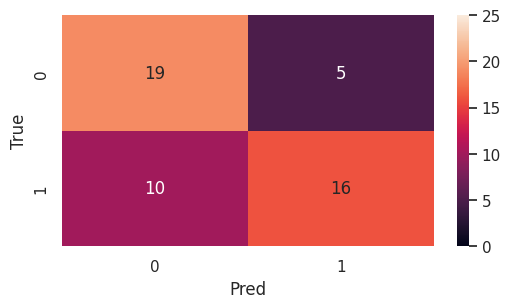

Test best model
mean pos: 115.82127807537715, std pos: 189.27156764503
mean neg: 107.01362818220387, std neg: 274.29831651406107
median pos: 24.87270164489746, median neg: 19.71688461303711
lowest pos: 0.0, highest pos: 847.1982421875
lowest neg: 0.0, highest neg: 1337.676025390625
accuracy: 0.54
precision: 0.6
recall: 0.4444444444444444
f1: 0.5106382978723405


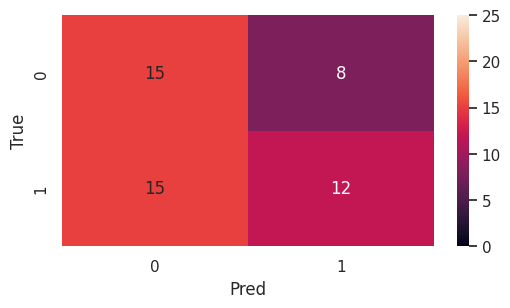

In [21]:
unnorm = UnNormalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))

loaderParams = dict(
    lblValidationMode = "Manual",
    balanced = True,
    anomalyObviousness = "obvious",
    distinctCAETraining = False,
    colorMode = "RGB",
    random_state = 1,
    set = "all",
    cameras = ["NEN1", "SBU3", "SBU4"], #must be fixed over training
)
np.random.seed(loaderParams["random_state"])

distributions = dict(
    gaussianFilterSize = [3, 5],
    gaussianFilterSigma = [1, 3, 5],
    filter = ["MinFilter"], #["MinFilter", "GaussianFilter"]
    zeroThreshold = np.random.uniform(low=0.1, high=0.4, size=30), # uniform dist on loc, loc+scale -> uniform(loc, scale) #threshold for zeroing out the image
    # sumThreshold = np.random.uniform(low=20, high=50, size=30),
    lossFn = ["L1"]#["MSE", "L1"],
)

sampler = ParameterSampler(distributions, n_iter=7, random_state=loaderParams["random_state"])

includeCameraProps = False
model = CAEV1

checkPoint = '/data/tim/heronWorkspace/logs/CAEV1/version_3/checkpoints/epoch=49-step=19350.ckpt'
caeLoaded = CAEHeron.load_from_checkpoint(checkPoint, model = model)
caeLoaded.freeze()
print(f'CAE Params:\n{caeLoaded.hparams}')

columns = ["trueLbl", "predictedLbl", "ImagePath", "includeCameraProps", "CAECheckPoint", "isCAETrainingCamera"] + list(loaderParams.keys()) + list(distributions.keys()) 

currBestParams = {}
currBestAcc = 0

for params in sampler:
    print(params)

    #Train
    print("Training")
    loaderParams["set"] = "train"
    trainVals = classify(params=params, caeModel=caeLoaded, loaderParams=loaderParams, mode="fit")
    onlyPos = trainVals[trainVals[:, 0] == 1]
    onlyNeg = trainVals[trainVals[:, 0] == 0]
    print(f'mean pos: {np.mean(onlyPos[:, 1])}, std pos: {np.std(onlyPos[:, 1])}, median pos: {np.median(onlyPos[:, 1])}')
    print(f'mean neg: {np.mean(onlyNeg[:, 1])}, std neg: {np.std(onlyNeg[:, 1])}, median neg: {np.median(onlyNeg[:, 1])}')

    newSumThreshold = (np.median(onlyPos[:, 1]) + np.median(onlyNeg[:, 1])) / 2

    params["sumThreshold"] = newSumThreshold

    #Validation
    print("Validation")
    loaderParams["set"] = "val"
    valVals = classify(params=params, caeModel=caeLoaded, loaderParams=loaderParams, mode="predict")
    plotEvalMetrics(valVals)
    acc = accuracy_score(valVals[:, 0], valVals[:,1])

    if acc > currBestAcc:
        currBestParams = params
        currBestAcc = acc
    # print(f'Accuracy: {acc}')

#Test
print("Test best model")
loaderParams["set"] = "test"
vals = classify(params=currBestParams, caeModel=caeLoaded, loaderParams=loaderParams, mode="predict")
plotEvalMetrics(vals)

